In [2]:
# Import essential libraries for data analysis and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from joblib import dump

import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# 🏥 Healthcare Premium Prediction: Comprehensive Data Analysis & Machine Learning 💻

This notebook performs end-to-end data preprocessing, exploratory data analysis, and machine learning modeling on healthcare premium data to predict insurance premium amounts based on demographic and health factors.

## 🎯 Objectives:
1. 📂 Load and preprocess healthcare premium dataset
2. 🧹 Perform comprehensive data cleaning and outlier treatment
3. 📊 Conduct univariate and bivariate exploratory data analysis
4. ⚙️ Engineer features and handle multicollinearity
5. 🤖 Train and evaluate multiple machine learning models
6. 📈 Analyze model performance and error patterns

---

## 📥 Data Loading & Initial Preprocessing 🔧
Loading the healthcare premium dataset and performing initial data exploration and standardization.

In [3]:
# Load healthcare premium data
df = pd.read_excel('premiums_young_with_gr.xlsx')
print(f"Dataset loaded successfully with shape: {df.shape}")
df.head()

Dataset loaded successfully with shape: (20096, 14)


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount,Genetical_Risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [4]:
# Standardize column names: convert to lowercase and replace spaces with underscores
print(f"Original dataset shape: {df.shape}")
df.columns = df.columns.str.replace(' ', '_').str.lower()
print(f"Standardized column names: {list(df.columns)}")

Original dataset shape: (20096, 14)
Standardized column names: ['age', 'gender', 'region', 'marital_status', 'number_of_dependants', 'bmi_category', 'smoking_status', 'employment_status', 'income_level', 'income_lakhs', 'medical_history', 'insurance_plan', 'annual_premium_amount', 'genetical_risk']


## 🧹 Exploratory Data Analysis & Data Cleaning

Systematic approach to handle data quality issues including missing values, duplicates, and data inconsistencies.

### 🔍 Handle Missing Values
Identifying and removing records with missing values to ensure data quality.

In [5]:
# Check and handle missing values
print("Missing values before cleaning:")
print(df.isna().sum())

# Remove rows with missing values
initial_shape = df.shape[0]
df.dropna(inplace=True)
final_shape = df.shape[0]

print(f"\nRemoved {initial_shape - final_shape} rows with missing values")
print("Missing values after cleaning:")
print(df.isna().sum())

Missing values before cleaning:
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64

Removed 6 rows with missing values
Missing values after cleaning:
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
genetical_risk           0
dtype: int64


### 🔄 Duplicate Records Removal 
Ensuring data uniqueness by identifying and removing duplicate entries.

In [6]:
# Check and remove duplicate records
initial_duplicates = df.duplicated().sum()
print(f"Duplicate records found: {initial_duplicates}")

df.drop_duplicates(inplace=True)
final_duplicates = df.duplicated().sum()

print(f"Duplicate records after removal: {final_duplicates}")
print(f"Final dataset shape: {df.shape}")

Duplicate records found: 0
Duplicate records after removal: 0
Final dataset shape: (20090, 14)


In [7]:
# Get statistical summary of numerical columns
print("Statistical summary of the dataset:")
df.describe()

Statistical summary of the dataset:


,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267,2.503932
std,2.294052,0.940713,23.420493,2749.906347,1.710203
min,18.000000,-3.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


### 🔧 Data Type Validation & Correction ✅
Fixing data inconsistencies and ensuring appropriate data types for analysis.

In [8]:
# Check for negative values in number_of_dependants
negative_dependants = df[df['number_of_dependants'] < 0]['number_of_dependants'].unique()
print(f"Negative values in dependants column: {negative_dependants}")

Negative values in dependants column: [-3 -1]


In [9]:
df.head()

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,4
3,25,Male,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,10L - 25L,15,No Disease,Bronze,5684,2
4,20,Male,Southeast,Unmarried,2,Overweight,No Smoking,Freelancer,10L - 25L,14,No Disease,Bronze,5712,1


In [10]:
# Convert negative values to positive (absolute values)
df['number_of_dependants'] = df['number_of_dependants'].abs()
print("Statistical summary after converting negative values:")
print(df.describe())

Statistical summary after converting negative values:
                age  number_of_dependants  income_lakhs  \
count  20090.000000          20090.000000  20090.000000   
mean      21.494375              0.722598     22.510851   
std        2.294052              0.937200     23.420493   
min       18.000000              0.000000      1.000000   
25%       19.000000              0.000000      6.000000   
50%       22.000000              0.000000     16.000000   
75%       23.000000              1.000000     31.000000   
max       25.000000              3.000000    790.000000   

       annual_premium_amount  genetical_risk  
count           20090.000000    20090.000000  
mean             8142.096267        2.503932  
std              2749.906347        1.710203  
min              3501.000000        0.000000  
25%              6022.250000        1.000000  
50%              7939.000000        3.000000  
75%              9561.000000        4.000000  
max             18186.000000        5.

## 📊 Exploratory Data Analysis (EDA) 🔍

Comprehensive analysis of both numerical and categorical variables to understand data distributions, relationships, and patterns.

### 📈 Numerical Variables Analysis 📊
Analyzing distributions, outliers, and relationships of continuous variables.

#### 📦 Box plots for numeric columns
Visual representation of data distribution and outlier identification.

In [11]:
# Identify numerical columns for analysis
numeric_col = df.select_dtypes(include=['float64','int64']).columns
print(f"Numerical columns identified for analysis: {list(numeric_col)}")

Numerical columns identified for analysis: ['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount', 'genetical_risk']


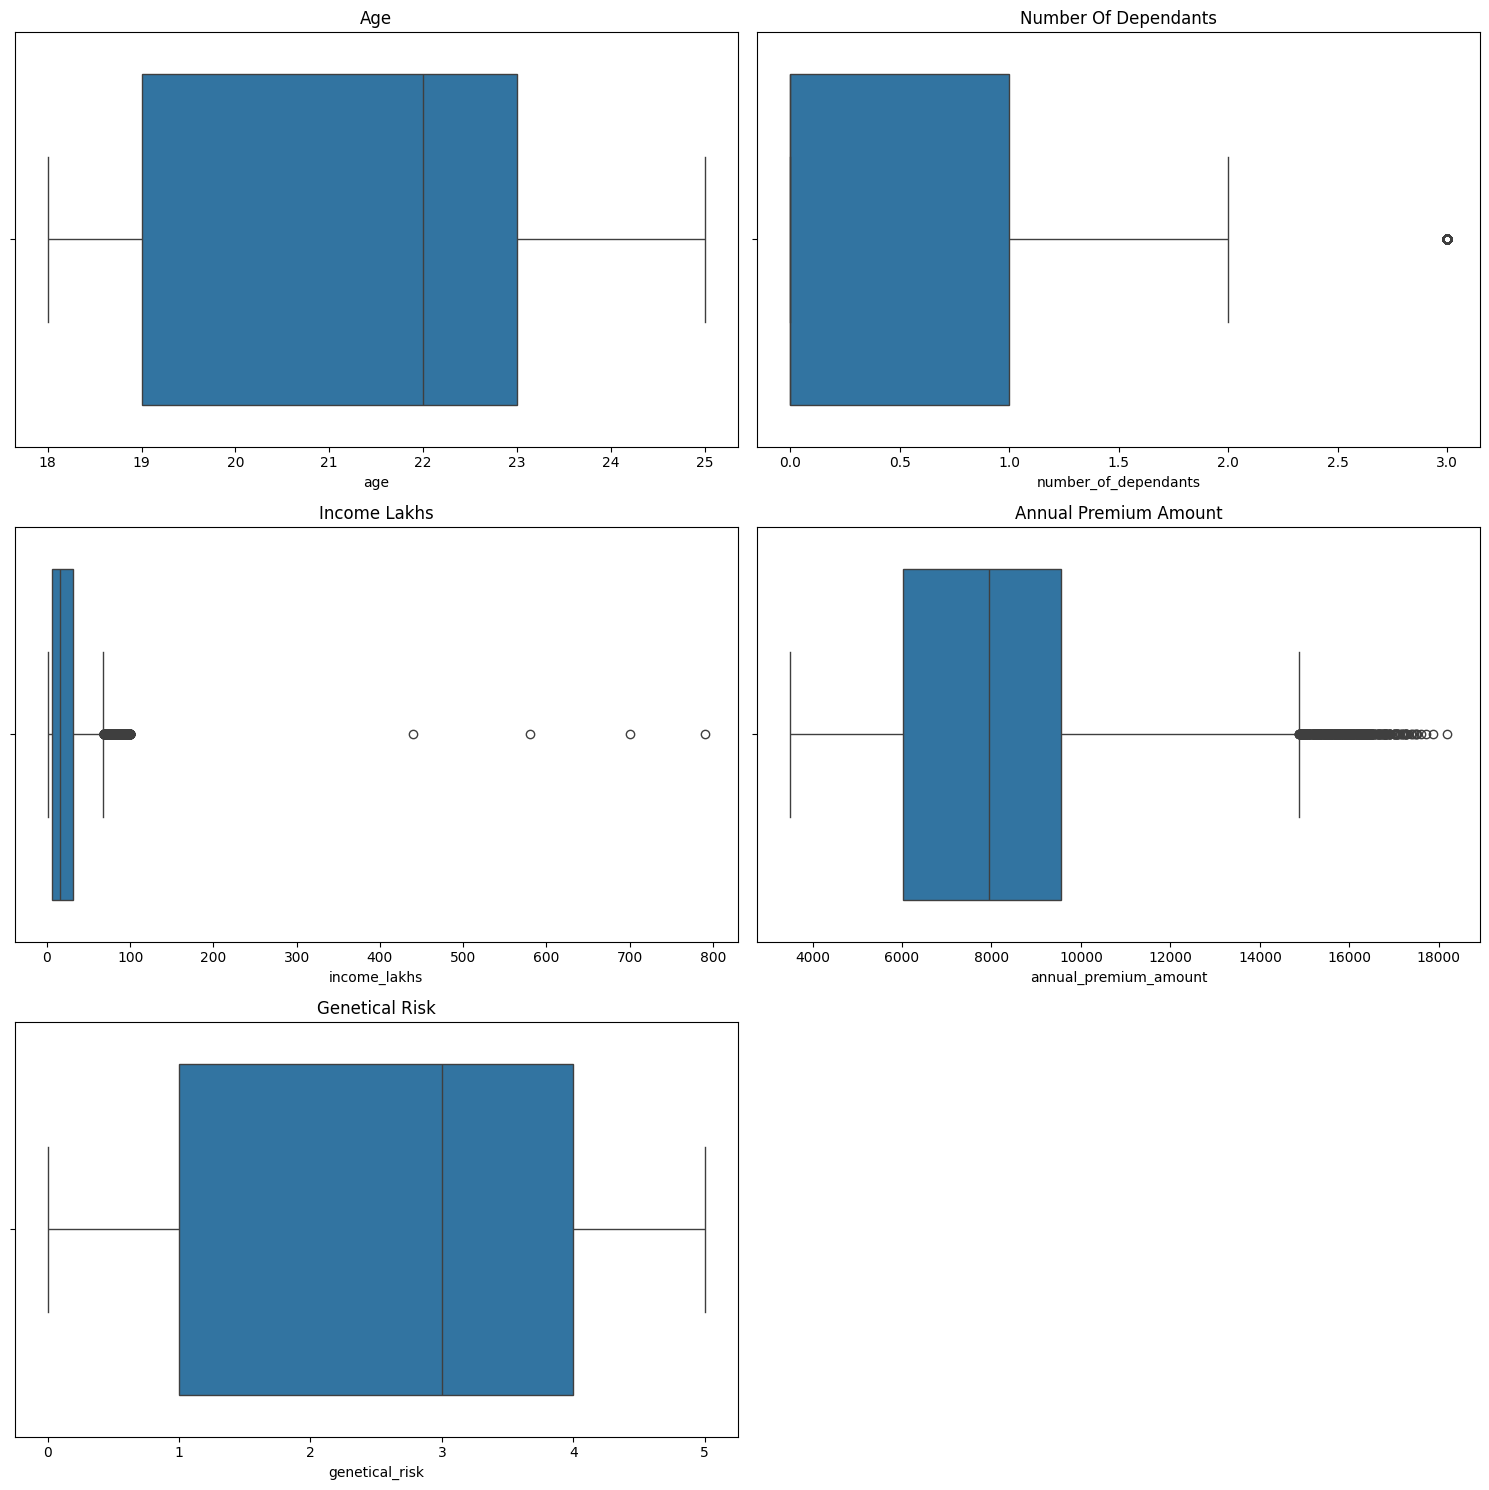

In [12]:
def plot_boxplots(df, numeric_cols):
    """Plot boxplots - 2 per row for outlier detection"""
    n = len(numeric_cols)
    rows = int(np.ceil(n / 2))
    
    fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
    axes = axes.flatten() if rows > 1 else [axes] if n == 1 else axes
    
    for i, col in enumerate(numeric_cols):
        sns.boxplot(x=df[col], ax=axes[i])
        axes[i].set_title(col.replace("_", " ").title())
    
    # Hide unused plots
    for i in range(n, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Generate box plots for all numerical columns
plot_boxplots(df, numeric_col)

### 🎂 Outlier Treatment: Age Column
Removing unrealistic age values (>100 years) to improve data quality.

In [13]:
# Identify extreme age values
extreme_ages = df[df['age'] > 100]['age'].unique()
print(f"Extreme age values found: {extreme_ages}")

Extreme age values found: []


In [14]:
# Create cleaned dataset by removing ages > 100
df1 = df[df['age'] < 100].copy()
print(f"Records removed due to extreme age: {len(df) - len(df1)}")
print("Statistical summary after age cleaning:")
df1.describe()

Records removed due to extreme age: 0
Statistical summary after age cleaning:


,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20090.000000,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267,2.503932
std,2.294052,0.937200,23.420493,2749.906347,1.710203
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.250000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,790.000000,18186.000000,5.000000


### 💰 Outlier Treatment: Income Column
Using quantile-based approach to handle income outliers while preserving data integrity.

In [15]:
def get_lower_upper(col):
    """Calculate outlier bounds using IQR method"""
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - IQR * 1.5
    upper = Q3 + IQR * 1.5
    return lower, upper

In [16]:
# Calculate outlier bounds for income
lower, upper = get_lower_upper(df1['income_lakhs'])
print(f"Income outlier bounds: Lower = {lower}, Upper = {upper}")
lower, upper

Income outlier bounds: Lower = -31.5, Upper = 68.5


(-31.5, 68.5)

In [17]:
# Check number of outliers above upper bound
outliers_count = df1[df1['income_lakhs'] > upper].shape[0]
print(f"Records with income outliers: {outliers_count}")
df1[df1['income_lakhs'] > upper].shape

Records with income outliers: 1295


(1295, 14)

In [18]:
# Use 99.9th percentile as threshold (conservative approach)
quantile_threshold = df1['income_lakhs'].quantile(0.999)
print(f"99.9th percentile threshold: {quantile_threshold}")
quantile_threshold

99.9th percentile threshold: 100.0


np.float64(100.0)

In [19]:
# Apply income filtering
initial_count = len(df1)
df2 = df1[df1['income_lakhs'] <= quantile_threshold].copy()
removed_count = initial_count - len(df1)

print(f"Records removed due to extreme income: {removed_count}")
df2.describe()

Records removed due to extreme income: 0


,age,number_of_dependants,income_lakhs,annual_premium_amount,genetical_risk
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263,2.503883
std,2.294248,0.937238,21.732062,2749.912486,1.710184
min,18.000000,0.000000,1.000000,3501.000000,0.000000
25%,19.000000,0.000000,6.000000,6022.000000,1.000000
50%,22.000000,0.000000,16.000000,7939.000000,3.000000
75%,23.000000,1.000000,31.000000,9561.000000,4.000000
max,25.000000,3.000000,100.000000,18186.000000,5.000000


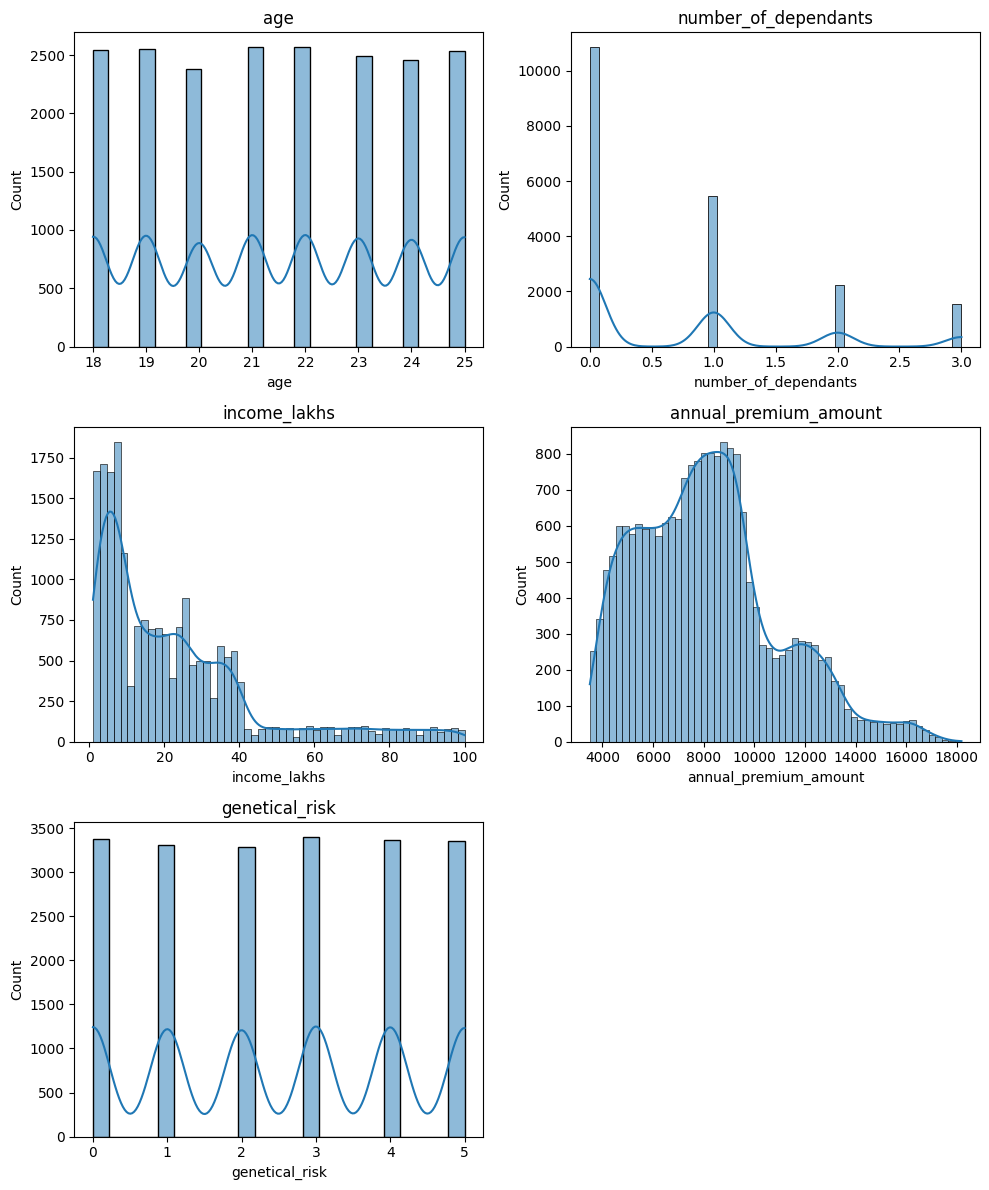

In [20]:
# Create histogram plots for cleaned numerical variables
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))  # 3 rows, 2 columns

# Flatten the axs array to make indexing easier
axs = axs.flatten()

for i, column in enumerate(numeric_col):
    ax = axs[i]  # Get the subplot from the flattened grid
    sns.histplot(df2[column], kde=True, ax=ax)
    ax.set_title(column)

# Hide the empty subplot (if any)
if len(numeric_col) < 6:
    axs[len(numeric_col)].axis('off')

plt.tight_layout()
plt.show()

In [21]:
# Display sample of cleaned data
df2.sample(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
14397,25,Female,Southwest,Unmarried,0,Normal,No Smoking,Self-Employed,<10L,8,No Disease,Bronze,5692,2
6886,25,Male,Southeast,Unmarried,1,Overweight,No Smoking,Salaried,<10L,7,No Disease,Bronze,7372,3
13337,20,Female,Southeast,Unmarried,0,Normal,No Smoking,Freelancer,<10L,6,No Disease,Bronze,4652,1


### 🔗 Bivariate Analysis: Numeric Columns
Analyzing relationships between numerical features and premium amounts.

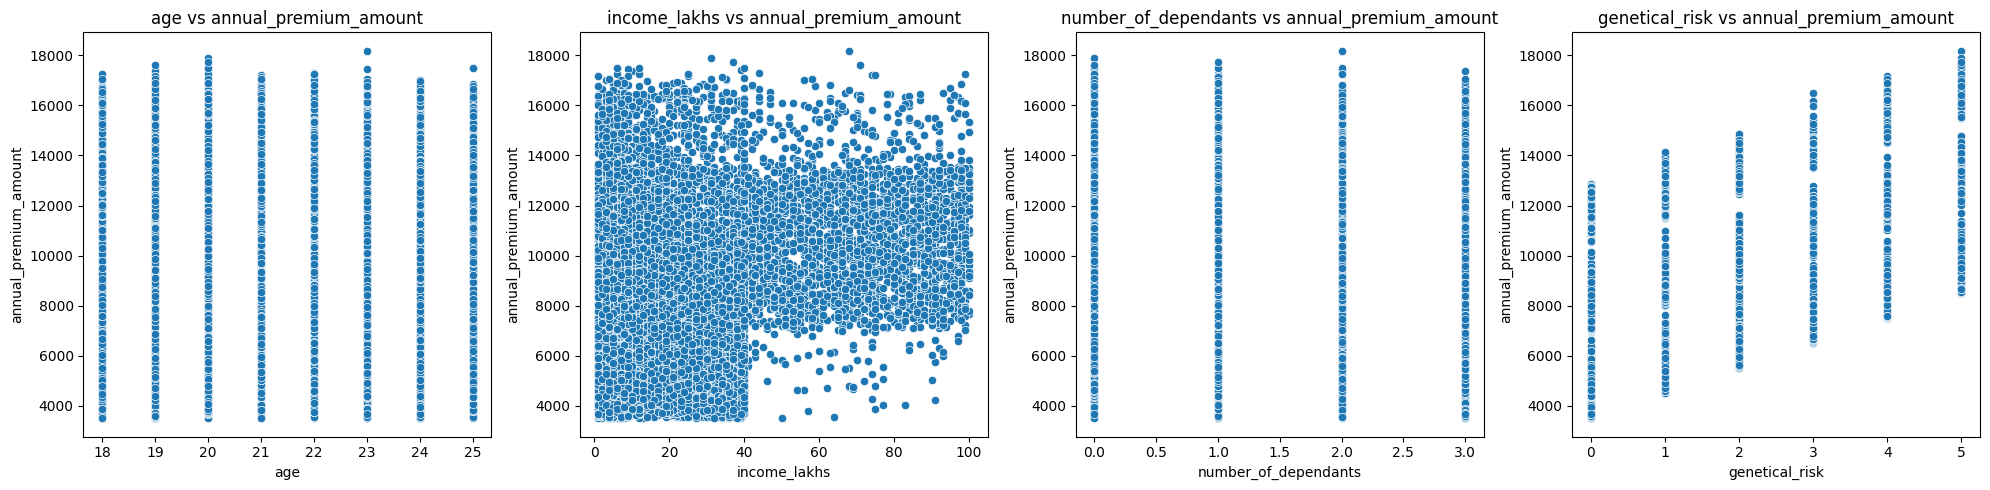

In [22]:
# List of numeric features to analyze relationships
numeric_feature = ['age', 'income_lakhs', 'number_of_dependants','genetical_risk']

# Create scatter plots for feature relationships
fig, axes = plt.subplots(1, len(numeric_feature), figsize=(5 * len(numeric_feature), 5))

# Plot each feature against premium amount
for i, feature in enumerate(numeric_feature):
    sns.scatterplot(x=df2[feature], y=df2['annual_premium_amount'], ax=axes[i])
    axes[i].set_title(f'{feature} vs annual_premium_amount')

plt.tight_layout()
plt.show()

### 📋 Categorical Variables Analysis 🏷️
Examining distributions and relationships of categorical variables through various visualization techniques.

In [23]:
# Identify and examine categorical columns
category_col = df2.select_dtypes(include=['O']).columns

# Display unique values for each categorical column
for col in category_col:
    print(f'{col}:', df2[col].unique())

gender: ['Male' 'Female']
region: ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status: ['Unmarried' 'Married']
bmi_category: ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status: ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status: ['Self-Employed' 'Freelancer' 'Salaried']
income_level: ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history: ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan: ['Silver' 'Bronze' 'Gold']


In [24]:
# Standardize smoking status categories
df2['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Does Not Smoke':'No Smoking',
    'Not Smoking':'No Smoking',
},inplace=True)
print("Standardized smoking status:", df2['smoking_status'].unique())

Standardized smoking status: ['Regular' 'No Smoking' 'Occasional']


### 📊 Univariate Analysis
Analyzing distribution of categorical variables using percentage-based visualizations.

In [25]:
# Calculate gender distribution percentages
pct_gender = df2['gender'].value_counts(normalize=True)*100
pct_gender

gender
Male      55.038335
Female    44.961665
Name: proportion, dtype: float64

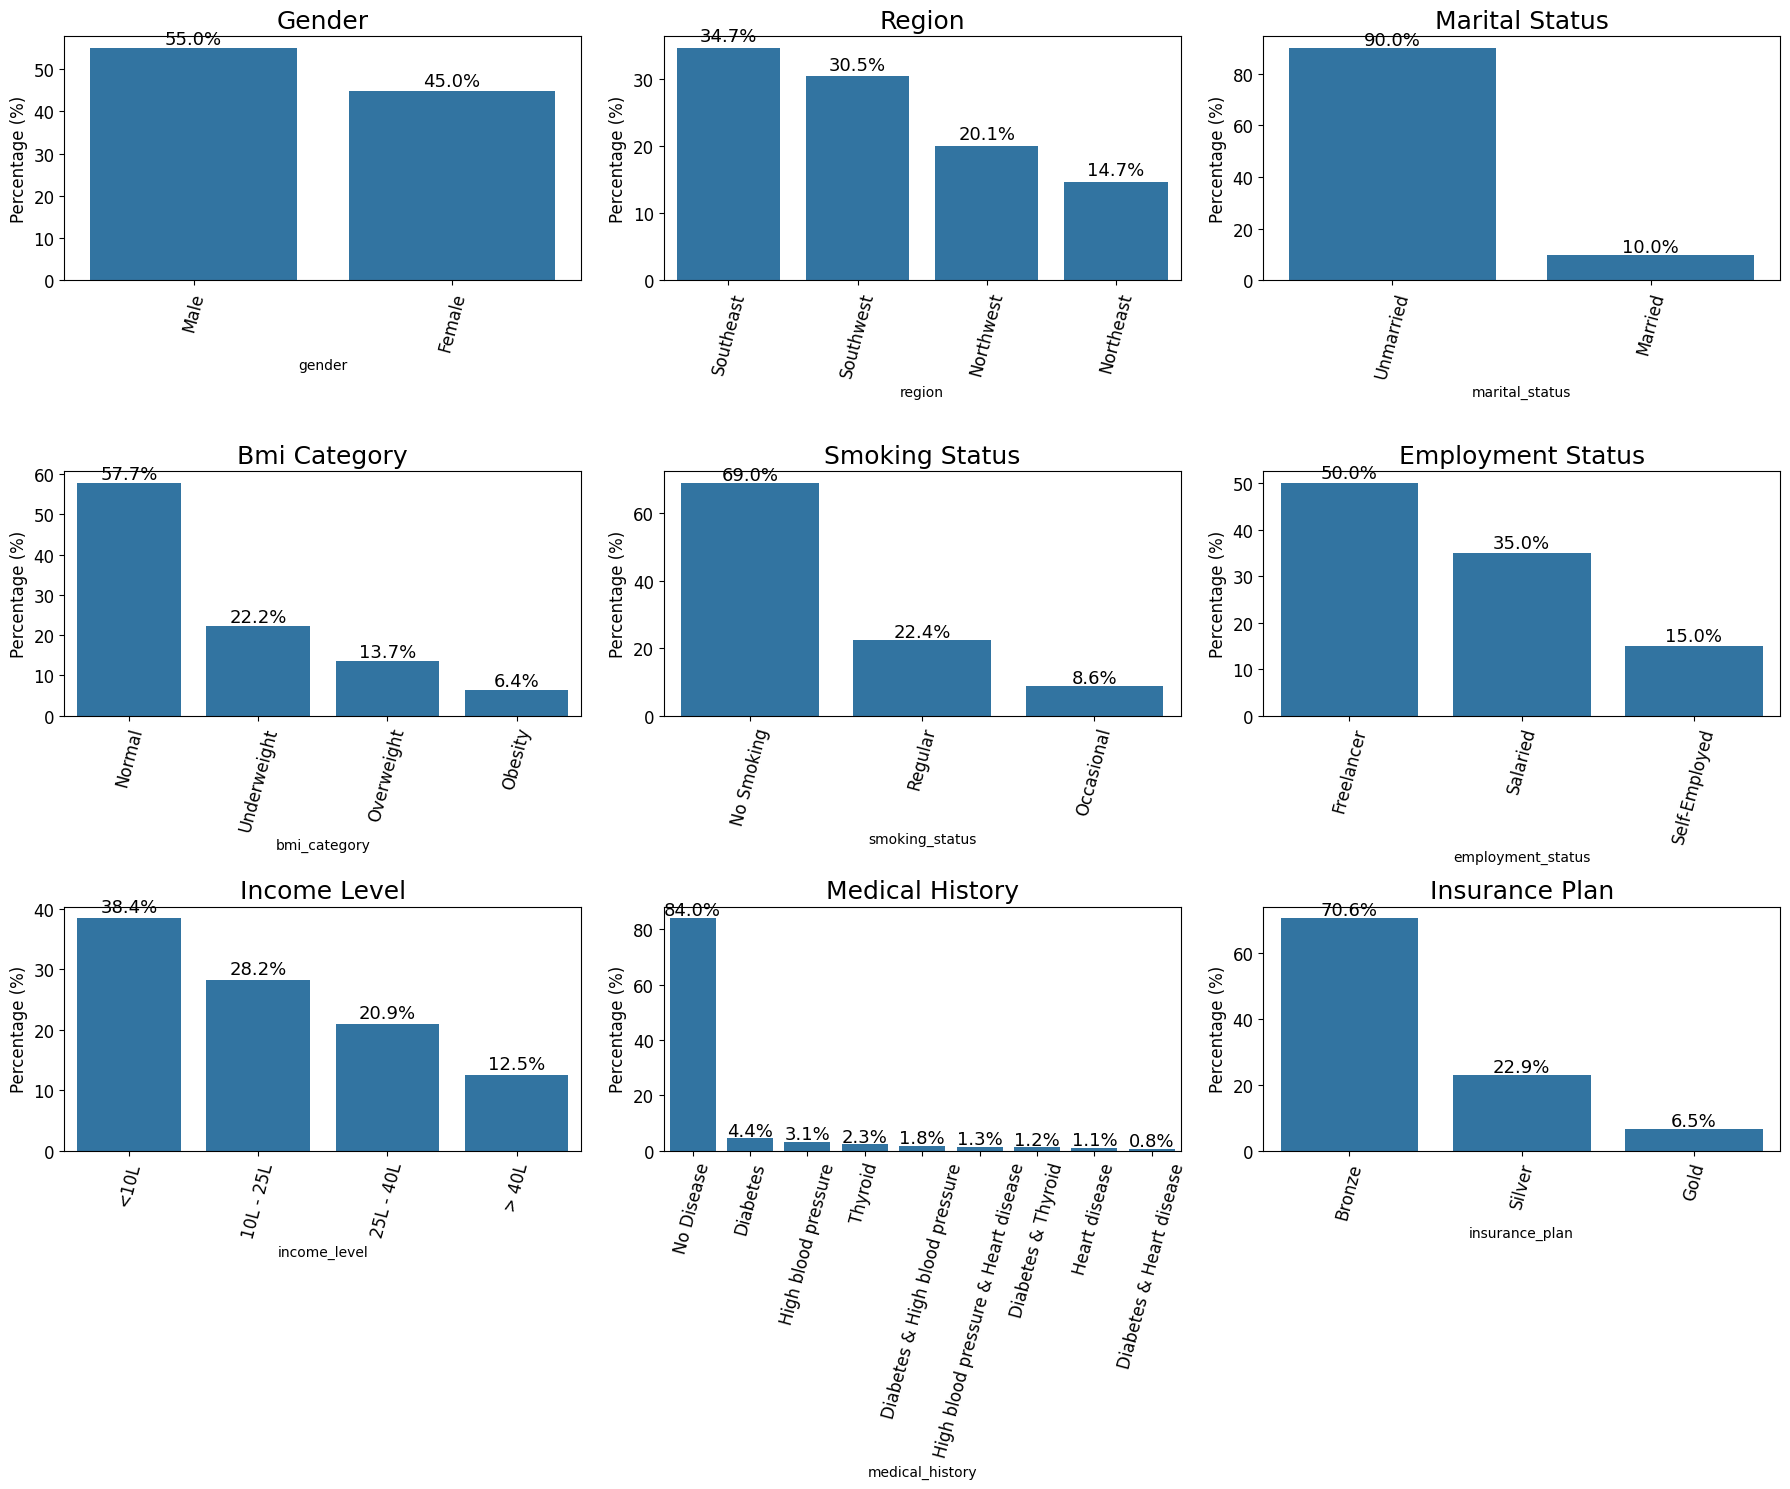

In [26]:
def plot_categories(df, columns, figsize=(18, 15)):
    """Create bar plots showing percentage distributions of categorical variables"""
    n_cols = len(columns)
    rows = int(np.ceil(n_cols / 3))
    cols = min(3, n_cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if n_cols > 1 else [axes]
    
    for i, col in enumerate(columns):
        # Calculate percentage distribution
        pct = df[col].value_counts(normalize=True) * 100
        
        # Create barplot
        sns.barplot(x=pct.index, y=pct.values, ax=axes[i])
        axes[i].set_title(f'{col.replace("_", " ").title()}', fontsize=18)
        axes[i].set_ylabel('Percentage (%)', fontsize=12)
        axes[i].tick_params(axis='x', rotation=75, labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)
        
        # Add percentage labels on bars
        for j, v in enumerate(pct.values):
            axes[i].text(j, v + 1, f'{v:.1f}%', ha='center', fontsize=13)
    
    # Hide unused subplots
    for i in range(n_cols, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Generate categorical distribution plots
plot_categories(df2, category_col)

### 🔗 Bivariate Analysis
Examining relationships between categorical variables using multiple visualization techniques.

Cross-tabulation: Income Level vs Insurance Plan
insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


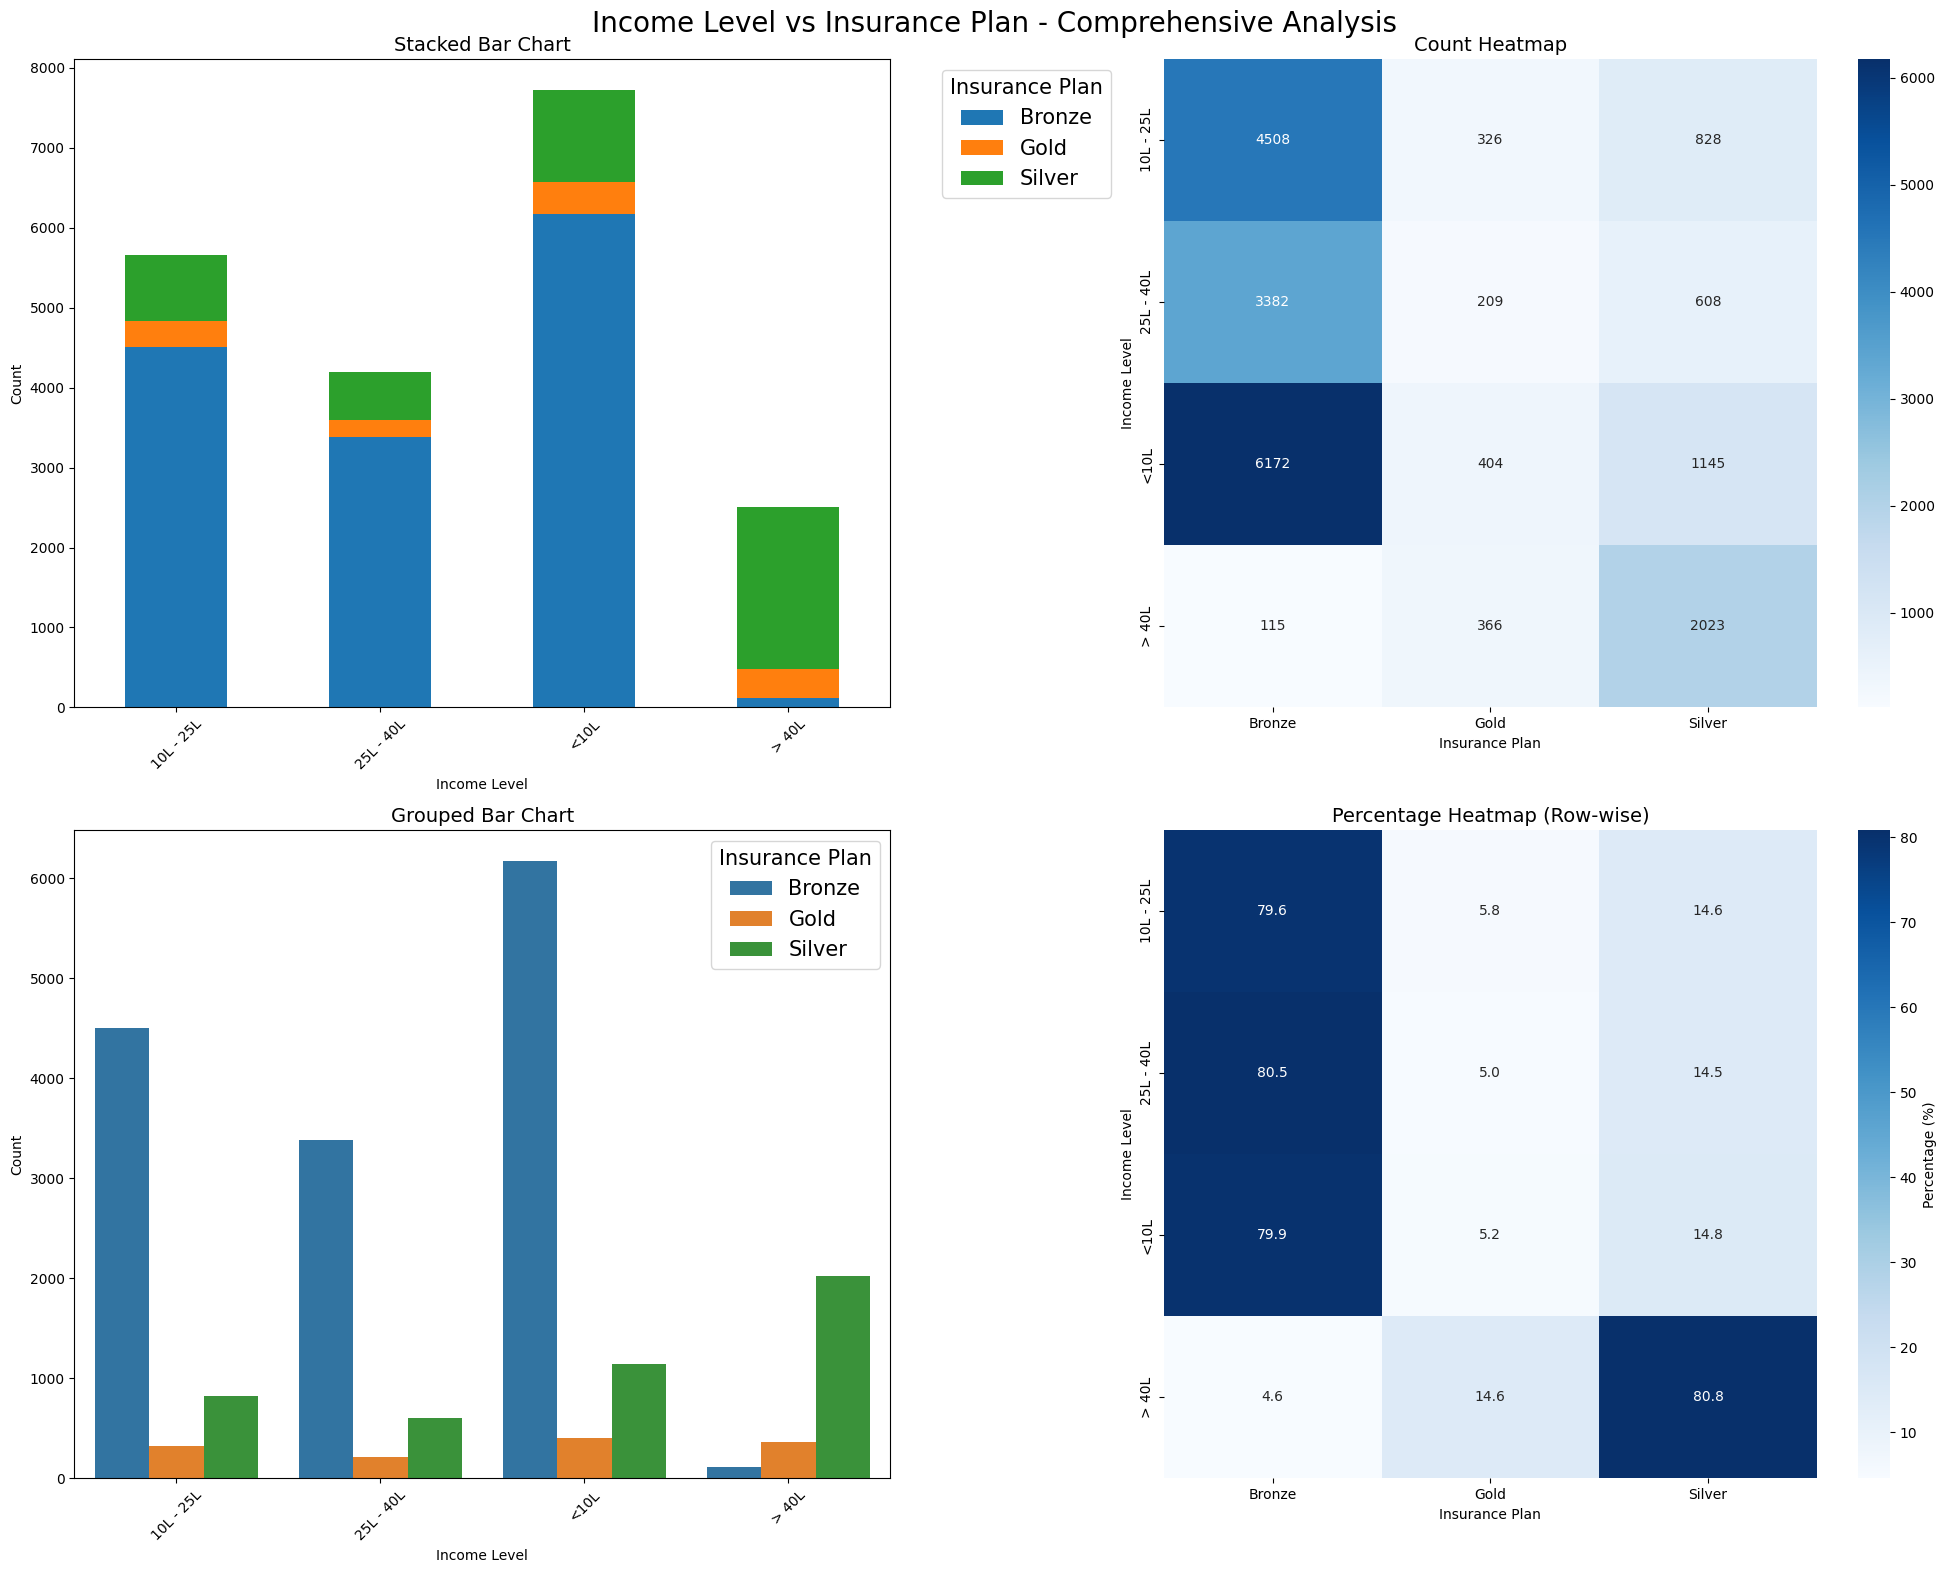

In [27]:
# Create comprehensive analysis of income level vs insurance plan relationship
crosstab = pd.crosstab(df2['income_level'], df2['insurance_plan'])
print("Cross-tabulation: Income Level vs Insurance Plan")
print(crosstab)

# Create subplot layout for multiple visualizations
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
fig.suptitle('Income Level vs Insurance Plan - Comprehensive Analysis', fontsize=20, y=0.98)

# Method 1: Stacked bar plot
crosstab.plot(kind='bar', stacked=True, ax=axes[0,0])
axes[0,0].set_title('Stacked Bar Chart', fontsize=14)
axes[0,0].set_xlabel('Income Level')
axes[0,0].set_ylabel('Count')
axes[0,0].tick_params(axis='x', rotation=45)
legend = axes[0,0].legend(title='Insurance Plan', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15)
legend.get_title().set_fontsize(15)

# Method 2: Heatmap visualization (Raw Counts)
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues', ax=axes[0,1])
axes[0,1].set_title('Count Heatmap', fontsize=14)
axes[0,1].set_xlabel('Insurance Plan')
axes[0,1].set_ylabel('Income Level')

# Method 3: Grouped bar chart
crosstab_reset = crosstab.reset_index().melt(id_vars='income_level', 
                                           var_name='insurance_plan', 
                                           value_name='count')
sns.barplot(data=crosstab_reset, x='income_level', y='count', hue='insurance_plan', ax=axes[1,0])
axes[1,0].set_title('Grouped Bar Chart', fontsize=14)
axes[1,0].set_xlabel('Income Level')
axes[1,0].set_ylabel('Count')
axes[1,0].tick_params(axis='x', rotation=45)
legend = axes[1,0].legend(title='Insurance Plan', fontsize=15)
legend.get_title().set_fontsize(15)

# Method 4: Percentage heatmap
crosstab_pct = pd.crosstab(df2['income_level'], df2['insurance_plan'], normalize='index') * 100
sns.heatmap(crosstab_pct, annot=True, fmt='.1f', cmap='Blues', 
            cbar_kws={'label': 'Percentage (%)'}, ax=axes[1,1])
axes[1,1].set_title('Percentage Heatmap (Row-wise)', fontsize=14)
axes[1,1].set_xlabel('Insurance Plan')
axes[1,1].set_ylabel('Income Level')

plt.tight_layout()
plt.show()

In [28]:
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3


## ⚙️ Advanced Feature Engineering 🛠️

Creating new features and transforming existing ones to improve model performance and interpretability.

### 🩺 Medical Risk Score Calculation ⚕️
Creating a composite risk score based on medical history to capture health-related premium factors.

In [29]:
# Define the risk scores for each condition
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure":6,
    "thyroid": 5,
    "no disease": 0,
    "none":0
}

df2[['disease1', 'disease2']] = df2['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())
df2['disease1'].fillna('none', inplace=True)
df2['disease2'].fillna('none', inplace=True)
df2['total_risk_score'] = 0

for disease in ['disease1', 'disease2']:
    df2['total_risk_score'] += df2[disease].map(risk_scores)

# Normalize the risk score to a range of 0 to 1
max_score = df2['total_risk_score'].max()
min_score = df2['total_risk_score'].min()
df2['normalized_risk_score'] = (df2['total_risk_score'] - min_score) / (max_score - min_score)
df2.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,4,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,3,no disease,none,0,0.000000


### 🔄 Categorical Encoding & Feature Transformation 📊
Converting categorical variables to numerical format and applying appropriate transformations.

In [30]:
df2['insurance_plan'] = df2['insurance_plan'].map({'Bronze':1, 'Silver':2, 'Gold':3})
df2['income_level'] = df2['income_level'].map({'<10L':1, '10L - 25L': 2, '25L - 40L':3, '> 40L':4})

nominal_cols = ['gender', 'region', 'marital_status', 'bmi_category', 'smoking_status', 'employment_status']
df3 = pd.get_dummies(df2, columns=nominal_cols, drop_first=True, dtype=int)
df3.head(3)

,age,number_of_dependants,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,genetical_risk,disease1,disease2,...,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,High blood pressure,2,13365,4,high blood pressure,none,...,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,No Disease,2,11050,3,no disease,none,...,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,No Disease,2,11857,4,no disease,none,...,1,0,1,0,0,0,0,1,1,0


In [31]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20086 entries, 0 to 20095
Data columns (total 24 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              20086 non-null  int64  
 1   number_of_dependants             20086 non-null  int64  
 2   income_level                     20086 non-null  int64  
 3   income_lakhs                     20086 non-null  int64  
 4   medical_history                  20086 non-null  object 
 5   insurance_plan                   20086 non-null  int64  
 6   annual_premium_amount            20086 non-null  int64  
 7   genetical_risk                   20086 non-null  int64  
 8   disease1                         20086 non-null  object 
 9   disease2                         20086 non-null  object 
 10  total_risk_score                 20086 non-null  int64  
 11  normalized_risk_score            20086 non-null  float64
 12  gender_Male            

In [32]:
df4 = df3.drop(columns=['medical_history','disease1','disease2','total_risk_score']).copy()
df4.head(3)

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,annual_premium_amount,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,4,99,2,13365,4,0.428571,1,0,0,0,1,0,1,0,0,1,0,1
1,22,0,1,3,2,11050,3,0.000000,0,1,0,0,1,0,0,1,0,0,0,0
2,21,0,4,97,2,11857,4,0.000000,0,0,1,0,1,0,0,0,0,1,1,0


### 🔗 Multicollinearity Assessment 📉
Detecting and addressing multicollinearity issues using Variance Inflation Factor (VIF) analysis.

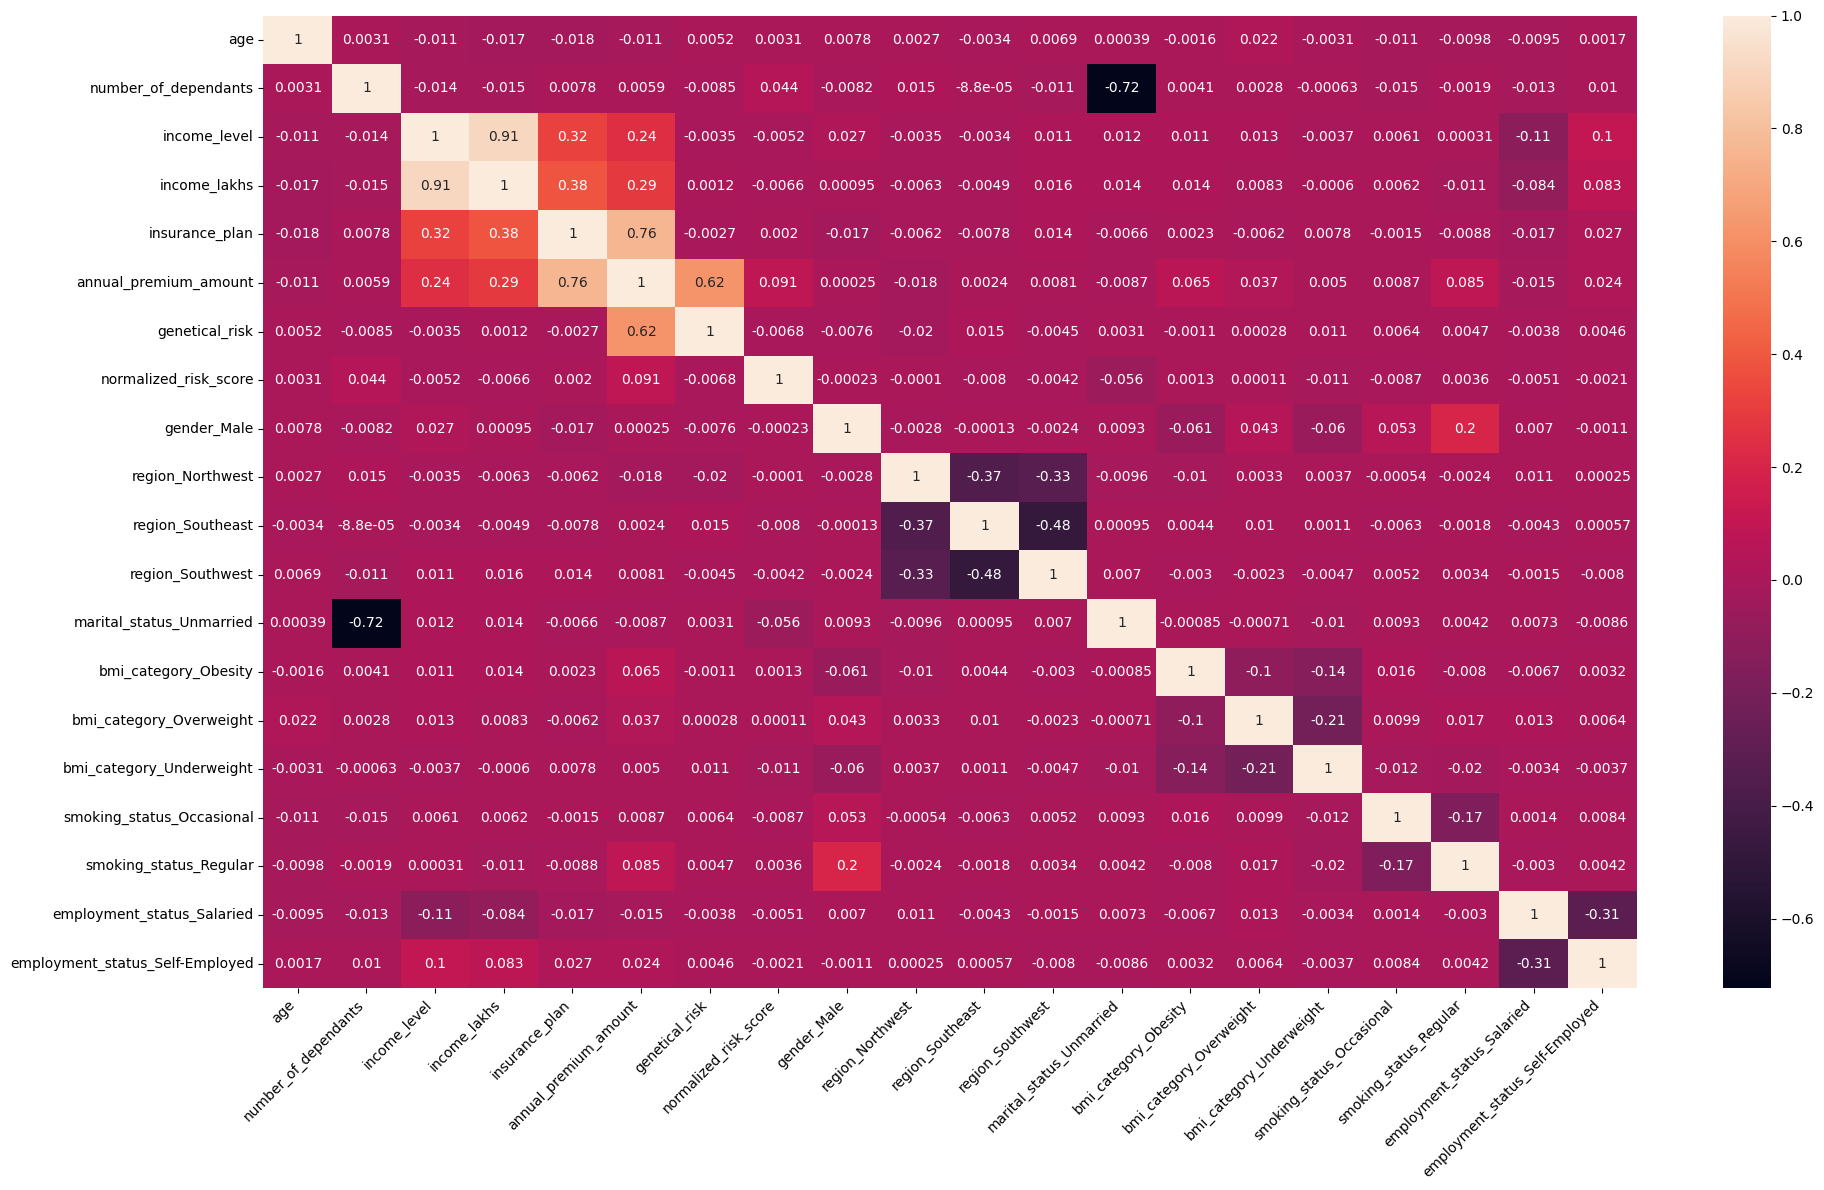

In [33]:
cm = df4.corr()

plt.figure(figsize=(20,12))
sns.heatmap(cm, annot=True)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [34]:
X = df4.drop('annual_premium_amount',axis=1)
y = df4['annual_premium_amount']

cols_to_scale = ['age','number_of_dependants', 'income_level',  'income_lakhs', 'insurance_plan','genetical_risk']
scaler = MinMaxScaler()

X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])
X.describe()

,age,number_of_dependants,income_level,income_lakhs,insurance_plan,genetical_risk,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.357994,0.216064,0.179578,0.500777,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.063527,0.136513,0.222493,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.347481,0.219516,0.300051,0.342037,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.243914,0.343341,0.415931,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.000000,0.050505,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.151515,0.000000,0.600000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.666667,0.303030,0.500000,0.800000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

calculate_vif(X)

,Column,VIF
0,age,3.154599
1,number_of_dependants,1.930428
2,income_level,11.928708
3,income_lakhs,11.876413
4,insurance_plan,1.592966
5,genetical_risk,2.981159
6,normalized_risk_score,1.154501
7,gender_Male,2.311831
8,region_Northwest,2.154355
9,region_Southeast,2.990493


In [36]:
X.drop('income_level',axis=1,inplace=True)
calculate_vif(X)

,Column,VIF
0,age,3.153255
1,number_of_dependants,1.927788
2,income_lakhs,2.294155
3,insurance_plan,1.587868
4,genetical_risk,2.981158
5,normalized_risk_score,1.154453
6,gender_Male,2.301658
7,region_Northwest,2.153423
8,region_Southeast,2.989301
9,region_Southwest,2.743932


## 🤖 Machine Learning Model Development & Evaluation 📊

Training and evaluating multiple regression models to predict healthcare premium amounts.

In [37]:
# Prepare features and target variable for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

# Display dataset split information
print("📊 Dataset Split Information:")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training target: {y_train.shape}")
print(f"Test target: {y_test.shape}")

📊 Dataset Split Information:
Training set: (14060, 18)
Test set: (6026, 18)
Training target: (14060,)
Test target: (6026,)


### 📊 Model Performance Comparison Framework 🏆
Setting up comprehensive evaluation framework for multiple algorithms and comparing their performance metrics.

In [38]:
# Initialize dictionary to store model performance results
model_results = {}

def evaluate_model(model, model_name, X_train, X_test, y_train, y_test):
    """
    Comprehensive model evaluation function
    
    Parameters:
    - model: Machine learning model to evaluate
    - model_name: String name for the model
    - X_train, X_test, y_train, y_test: Training and test datasets
    
    Returns:
    - model: Trained model
    - y_pred_test: Test predictions
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate comprehensive performance metrics
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    mse = mean_squared_error(y_test, y_pred_test)
    rmse = np.sqrt(mse)
    
    # Calculate additional metrics
    mae = np.mean(np.abs(y_test - y_pred_test))
    mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
    
    # Store results in global dictionary
    model_results[model_name] = {
        'train_r2': train_score,
        'test_r2': test_score,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape
    }
    
    # Display results
    print(f"🎯 {model_name} Performance Metrics:")
    print(f"   📈 Training R²: {train_score:.4f}")
    print(f"   📊 Test R²: {test_score:.4f}")
    print(f"   📉 MSE: {mse:.2f}")
    print(f"   🎲 RMSE: {rmse:.2f}")
    print(f"   📋 MAE: {mae:.2f}")
    print(f"   📊 MAPE: {mape:.2f}%")
    print("-" * 50)
    
    return model, y_pred_test

### 📉 Linear Regression Baseline Model 📊
Implementing basic linear regression as baseline for comparison.

🚀 Training Linear Regression Model...
🎯 Linear Regression Performance Metrics:
   📈 Training R²: 0.9883
   📊 Test R²: 0.9887
   📉 MSE: 85732.34
   🎲 RMSE: 292.80
   📋 MAE: 251.64
   📊 MAPE: 3.48%
--------------------------------------------------


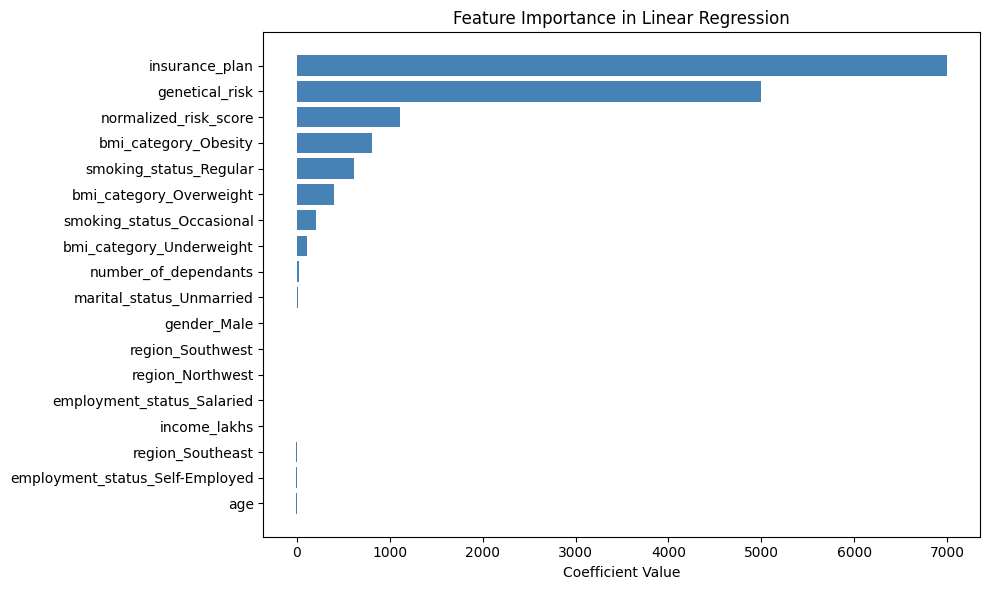

🔝 Top 5 Positive Coefficients:
   insurance_plan: 7001.1253
   genetical_risk: 4996.9887
   normalized_risk_score: 1109.1484
   bmi_category_Obesity: 812.8449
   smoking_status_Regular: 610.9833

🔻 Top 5 Negative Coefficients:
   age: -7.2290
   employment_status_Self-Employed: -5.2420
   region_Southeast: -3.2753
   income_lakhs: -1.2645
   employment_status_Salaried: 0.0388


In [39]:
# 📉 Linear Regression Model - Baseline Model
print("🚀 Training Linear Regression Model...")
lr = LinearRegression()
lr_model, lr_predictions = evaluate_model(lr, "Linear Regression", X_train, X_test, y_train, y_test)

# Feature importance visualization for Linear Regression
feature_importance = lr_model.coef_
coef_df = pd.DataFrame(feature_importance, index=X_test.columns, columns=['Coefficient'])
coef_df = coef_df.sort_values('Coefficient', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(coef_df.index, coef_df['Coefficient'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.tight_layout()
plt.show()

# Display top positive and negative coefficients
print("🔝 Top 5 Positive Coefficients:")
top_positive = coef_df.sort_values('Coefficient', ascending=False).head(5)
for feature, coef in top_positive.iterrows():
    print(f"   {feature}: {coef['Coefficient']:.4f}")

print("\n🔻 Top 5 Negative Coefficients:")
top_negative = coef_df.sort_values('Coefficient', ascending=True).head(5)
for feature, coef in top_negative.iterrows():
    print(f"   {feature}: {coef['Coefficient']:.4f}")

### 🔵 Ridge Regression Model 🛡️
Implementing Ridge regression to handle multicollinearity through L2 regularization.

🚀 Training Ridge Regression Model...
🎯 Ridge Regression Performance Metrics:
   📈 Training R²: 0.9883
   📊 Test R²: 0.9887
   📉 MSE: 85722.72
   🎲 RMSE: 292.78
   📋 MAE: 251.63
   📊 MAPE: 3.48%
--------------------------------------------------


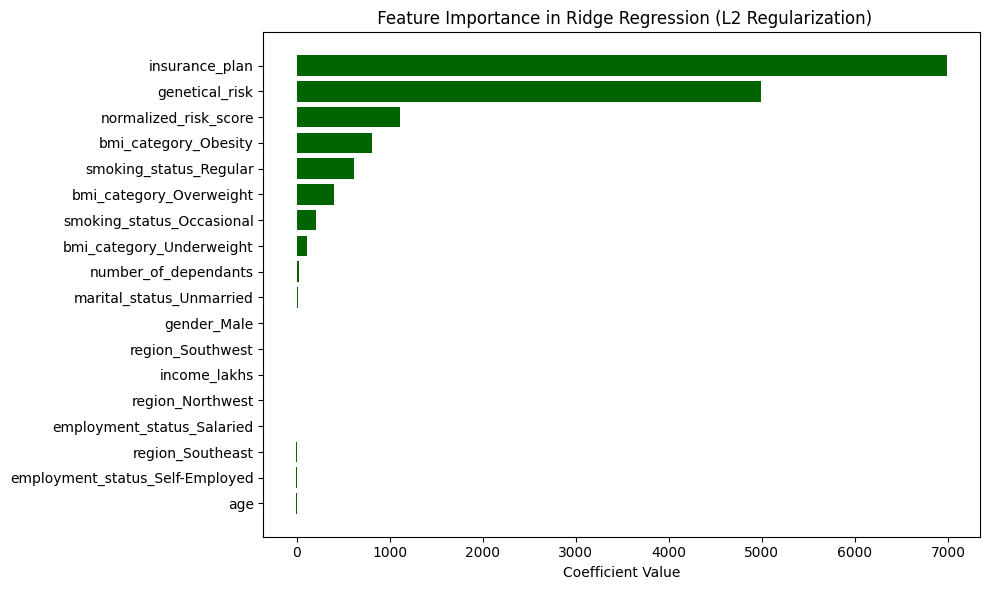

🔍 Coefficient Comparison (Ridge vs Linear Regression):
Top 5 Most Shrunk Features:
   income_lakhs: 276.21% shrinkage
   employment_status_Salaried: -149.20% shrinkage
   region_Northwest: 11.43% shrinkage
   region_Southeast: -3.43% shrinkage
   region_Southwest: 1.65% shrinkage


In [40]:
# 🔵 Ridge Regression Model - L2 Regularization
print("🚀 Training Ridge Regression Model...")
ridge = Ridge(alpha=1.0, random_state=42)
ridge_model, ridge_predictions = evaluate_model(ridge, "Ridge Regression", X_train, X_test, y_train, y_test)

# Feature importance visualization for Ridge Regression
ridge_coef_df = pd.DataFrame(ridge_model.coef_, index=X_test.columns, columns=['Coefficient'])
ridge_coef_df = ridge_coef_df.sort_values('Coefficient', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(ridge_coef_df.index, ridge_coef_df['Coefficient'], color='darkgreen')
plt.xlabel('Coefficient Value')
plt.title(' Feature Importance in Ridge Regression (L2 Regularization)')
plt.tight_layout()
plt.show()

# Compare coefficient shrinkage with Linear Regression
print("🔍 Coefficient Comparison (Ridge vs Linear Regression):")
comparison_df = pd.DataFrame({
    'Linear_Regression': lr_model.coef_,
    'Ridge_Regression': ridge_model.coef_
}, index=X_test.columns)
comparison_df['Shrinkage'] = comparison_df['Linear_Regression'] - comparison_df['Ridge_Regression']
comparison_df['Shrinkage_Pct'] = (comparison_df['Shrinkage'] / comparison_df['Linear_Regression']) * 100

print("Top 5 Most Shrunk Features:")
most_shrunk = comparison_df.reindex(comparison_df['Shrinkage_Pct'].abs().sort_values(ascending=False).index).head(5)
for feature, row in most_shrunk.iterrows():
    print(f"   {feature}: {row['Shrinkage_Pct']:.2f}% shrinkage")

### 🟠 Lasso Regression Model ✂️
Implementing Lasso regression for feature selection through L1 regularization.

🚀 Training Lasso Regression Model...
🎯 Lasso Regression Performance Metrics:
   📈 Training R²: 0.9883
   📊 Test R²: 0.9887
   📉 MSE: 85707.86
   🎲 RMSE: 292.76
   📋 MAE: 251.61
   📊 MAPE: 3.47%
--------------------------------------------------


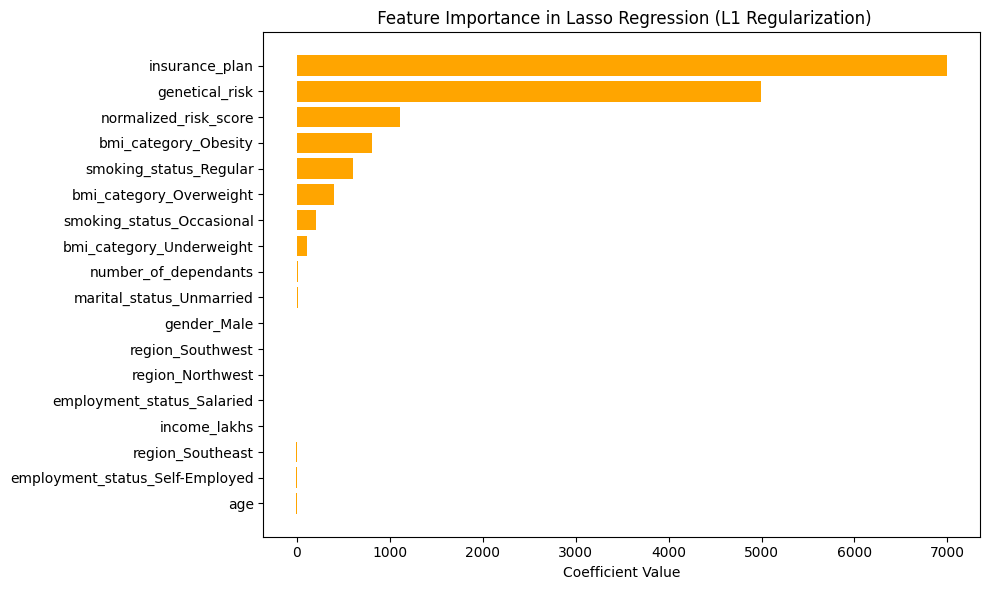

✂️ Feature Selection Results:
   🟢 Selected features: 16 out of 18
   🔴 Eliminated features: 2

🟢 Selected Features:
   age: -6.2765
   employment_status_Self-Employed: -4.4878
   region_Southeast: -3.8386
   region_Northwest: 0.2596
   region_Southwest: 5.1350
   gender_Male: 7.8312
   marital_status_Unmarried: 12.0903
   number_of_dependants: 15.8154
   bmi_category_Underweight: 106.4592
   smoking_status_Occasional: 203.6569
   bmi_category_Overweight: 399.1379
   smoking_status_Regular: 610.2951
   bmi_category_Obesity: 810.7044
   normalized_risk_score: 1107.1534
   genetical_risk: 4996.0718
   insurance_plan: 6999.6261

🔴 Eliminated Features:
   income_lakhs
   employment_status_Salaried


In [41]:
# 🟠 Lasso Regression Model - L1 Regularization for Feature Selection
print("🚀 Training Lasso Regression Model...")
lasso = Lasso(alpha=0.1, random_state=42)
lasso_model, lasso_predictions = evaluate_model(lasso, "Lasso Regression", X_train, X_test, y_train, y_test)

# Feature importance visualization for Lasso Regression
lasso_coef_df = pd.DataFrame(lasso_model.coef_, index=X_test.columns, columns=['Coefficient'])
lasso_coef_df = lasso_coef_df.sort_values('Coefficient', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(lasso_coef_df.index, lasso_coef_df['Coefficient'], color='orange')
plt.xlabel('Coefficient Value')
plt.title(' Feature Importance in Lasso Regression (L1 Regularization)')
plt.tight_layout()
plt.show()

# Feature Selection Analysis
selected_features = lasso_coef_df[lasso_coef_df['Coefficient'] != 0]
eliminated_features = lasso_coef_df[lasso_coef_df['Coefficient'] == 0]

print(f"✂️ Feature Selection Results:")
print(f"   🟢 Selected features: {len(selected_features)} out of {len(lasso_coef_df)}")
print(f"   🔴 Eliminated features: {len(eliminated_features)}")

print(f"\n🟢 Selected Features:")
for feature, coef in selected_features.iterrows():
    print(f"   {feature}: {coef['Coefficient']:.4f}")

print(f"\n🔴 Eliminated Features:")
for feature in eliminated_features.index:
    print(f"   {feature}")

### 🌳 Random Forest Regression Model 🌲
Implementing ensemble method to capture non-linear relationships and feature interactions.

🚀 Training Random Forest Regression Model...
🎯 Random Forest Performance Metrics:
   📈 Training R²: 0.9901
   📊 Test R²: 0.9881
   📉 MSE: 90421.07
   🎲 RMSE: 300.70
   📋 MAE: 255.71
   📊 MAPE: 3.51%
--------------------------------------------------


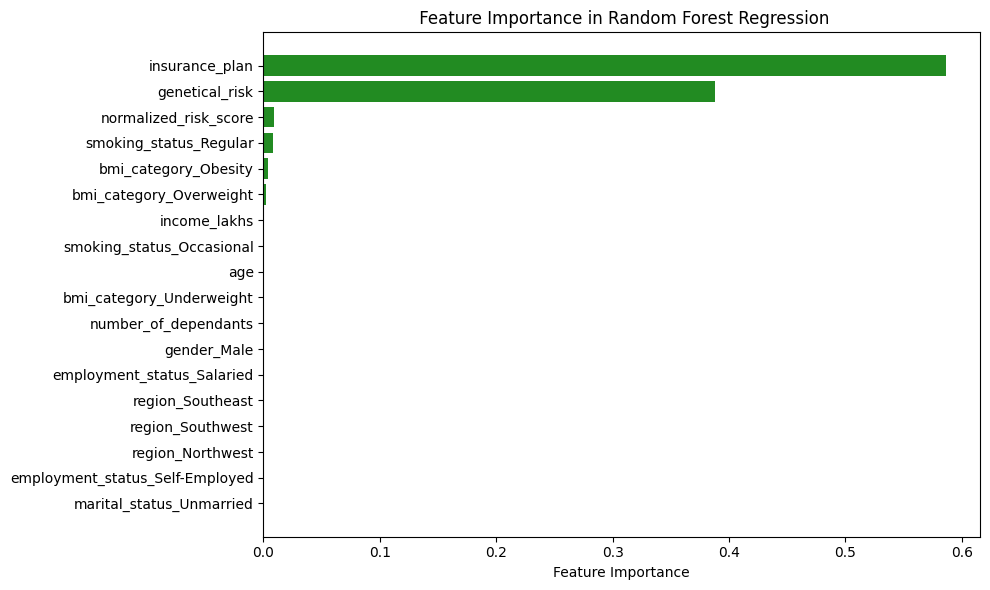

🌲 Top 10 Most Important Features in Random Forest:
 1. insurance_plan: 0.5863
 2. genetical_risk: 0.3878
 3. normalized_risk_score: 0.0094
 4. smoking_status_Regular: 0.0080
 5. bmi_category_Obesity: 0.0043
 6. bmi_category_Overweight: 0.0021
 7. income_lakhs: 0.0006
 8. smoking_status_Occasional: 0.0004
 9. age: 0.0004
10. bmi_category_Underweight: 0.0002

🌳 Random Forest Insights:
   🌲 Number of trees: 100
   📊 Max depth: 10
   📋 Min samples split: 5
   🎯 Out-of-bag score: N/A


In [42]:
# 🌳 Random Forest Regression Model - Ensemble Method
print("🚀 Training Random Forest Regression Model...")
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model, rf_predictions = evaluate_model(rf, "Random Forest", X_train, X_test, y_train, y_test)

# Feature importance visualization for Random Forest
rf_importance = rf_model.feature_importances_
rf_coef_df = pd.DataFrame(rf_importance, index=X_train.columns, columns=['Importance'])
rf_coef_df = rf_coef_df.sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(rf_coef_df.index, rf_coef_df['Importance'], color='forestgreen')
plt.xlabel('Feature Importance')
plt.title(' Feature Importance in Random Forest Regression')
plt.tight_layout()
plt.show()

# Display top important features
print("🌲 Top 10 Most Important Features in Random Forest:")
top_features = rf_coef_df.sort_values('Importance', ascending=False).head(10)
for i, (feature, importance) in enumerate(top_features.iterrows(), 1):
    print(f"{i:2d}. {feature}: {importance['Importance']:.4f}")

# Tree-based feature importance insights
print(f"\n🌳 Random Forest Insights:")
print(f"   🌲 Number of trees: {rf_model.n_estimators}")
print(f"   📊 Max depth: {rf_model.max_depth}")
print(f"   📋 Min samples split: {rf_model.min_samples_split}")
print(f"   🎯 Out-of-bag score: {rf_model.oob_score_ if hasattr(rf_model, 'oob_score_') else 'N/A'}")

### 🚀 XGBoost Regression Model ⚡
Implementing gradient boosting with basic configuration.

🚀 Training XGBoost Regression Model...
🎯 XGBoost (Basic) Performance Metrics:
   📈 Training R²: 0.9925
   📊 Test R²: 0.9877
   📉 MSE: 93312.70
   🎲 RMSE: 305.47
   📋 MAE: 258.84
   📊 MAPE: 3.56%
--------------------------------------------------


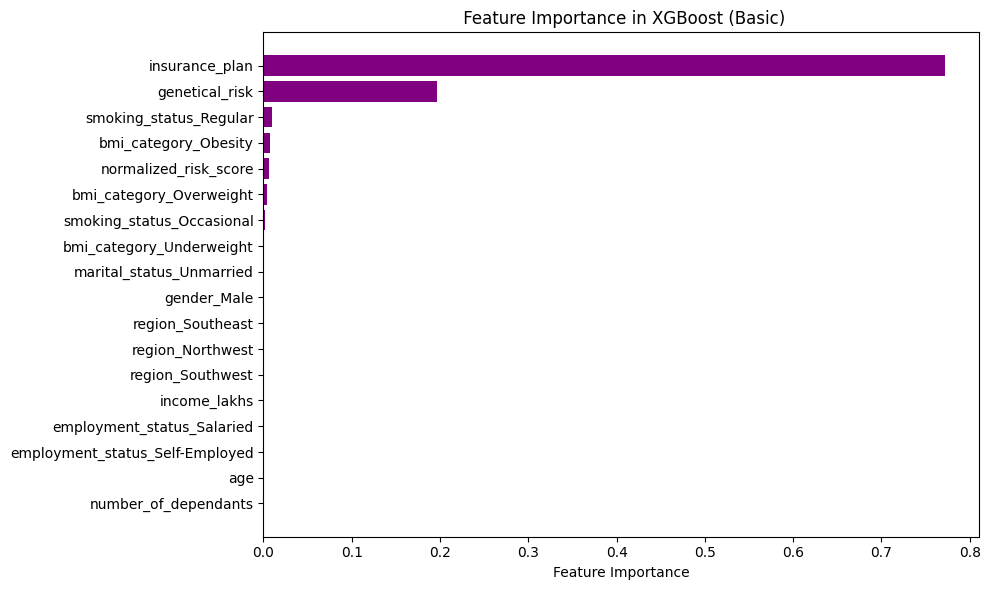

In [43]:
# 🚀 XGBoost Regression Model - Basic Configuration
print("🚀 Training XGBoost Regression Model...")
xgb_basic = XGBRegressor(random_state=42)
xgb_model, xgb_predictions = evaluate_model(xgb_basic, "XGBoost (Basic)", X_train, X_test, y_train, y_test)

# Feature importance visualization for XGBoost
xgb_importance = xgb_model.feature_importances_
xgb_coef_df = pd.DataFrame(xgb_importance, index=X_train.columns, columns=['Importance'])
xgb_coef_df = xgb_coef_df.sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(xgb_coef_df.index, xgb_coef_df['Importance'], color='purple')
plt.xlabel('Feature Importance')
plt.title(' Feature Importance in XGBoost (Basic)')
plt.tight_layout()
plt.show()

### ⚡ XGBoost with Hyperparameter Tuning 🎯
Optimizing XGBoost performance through automated hyperparameter search.

🎯 Performing XGBoost Hyperparameter Tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
🎯 Best XGBoost Parameters: {'subsample': 1.0, 'n_estimators': 50, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
📊 Best Cross-Validation Score: 0.9885
🎯 XGBoost (Optimized) Performance Metrics:
   📈 Training R²: 0.9896
   📊 Test R²: 0.9889
   📉 MSE: 84788.88
   🎲 RMSE: 291.19
   📋 MAE: 250.05
   📊 MAPE: 3.45%
--------------------------------------------------


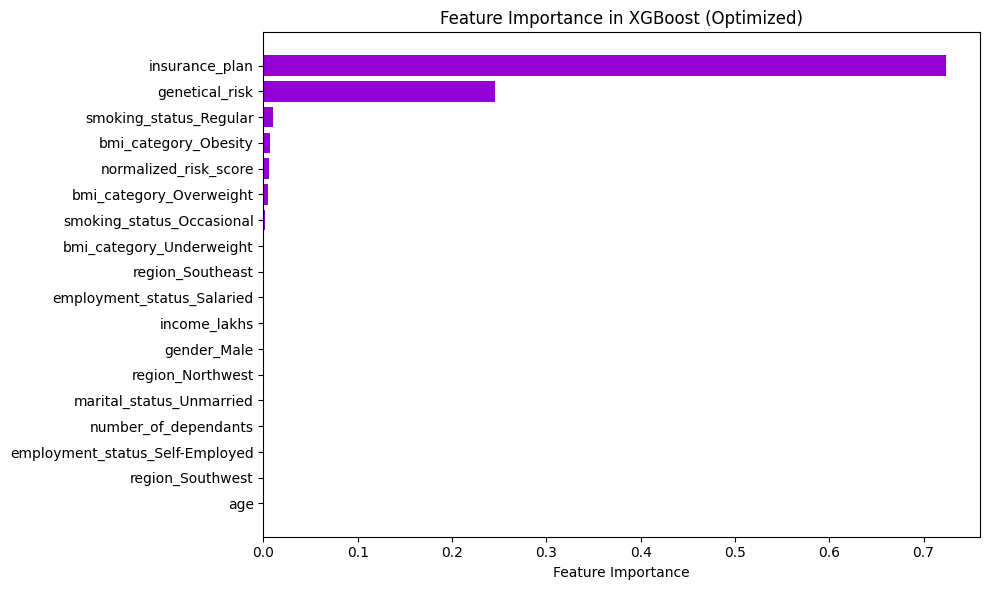

🔍 XGBoost Performance Comparison:
   Basic XGBoost R²: 0.9877
   Optimized XGBoost R²: 0.9889
   📈 Improvement: 0.0011 (0.11%)


In [44]:
# ⚡ XGBoost with Hyperparameter Tuning
print("🎯 Performing XGBoost Hyperparameter Tuning...")

# Define parameter grid for optimization
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Perform randomized search for optimal parameters
xgb_tuned = XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(
    xgb_tuned, 
    param_grid, 
    n_iter=20,  # Number of parameter combinations to try
    cv=5,       # 5-fold cross validation
    scoring='r2', 
    random_state=42, 
    n_jobs=-1,
    verbose=1
)

# Fit the randomized search
random_search.fit(X_train, y_train)

print(f"🎯 Best XGBoost Parameters: {random_search.best_params_}")
print(f"📊 Best Cross-Validation Score: {random_search.best_score_:.4f}")

# Evaluate the optimized model
best_xgb_model = random_search.best_estimator_
best_xgb_model, best_xgb_predictions = evaluate_model(
    best_xgb_model, "XGBoost (Optimized)", X_train, X_test, y_train, y_test
)

# Feature importance for optimized XGBoost
best_xgb_importance = best_xgb_model.feature_importances_
best_xgb_coef_df = pd.DataFrame(best_xgb_importance, index=X_train.columns, columns=['Importance'])
best_xgb_coef_df = best_xgb_coef_df.sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(best_xgb_coef_df.index, best_xgb_coef_df['Importance'], color='darkviolet')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in XGBoost (Optimized)')
plt.tight_layout()
plt.show()

# Compare basic vs optimized XGBoost
print("🔍 XGBoost Performance Comparison:")
print(f"   Basic XGBoost R²: {model_results['XGBoost (Basic)']['test_r2']:.4f}")
print(f"   Optimized XGBoost R²: {model_results['XGBoost (Optimized)']['test_r2']:.4f}")
improvement = model_results['XGBoost (Optimized)']['test_r2'] - model_results['XGBoost (Basic)']['test_r2']
print(f"   📈 Improvement: {improvement:.4f} ({improvement/model_results['XGBoost (Basic)']['test_r2']*100:.2f}%)")

### 📊 Comprehensive Model Performance Summary 🏆
Detailed comparison of all trained models to identify the best performer.

🏆 COMPREHENSIVE MODEL PERFORMANCE SUMMARY
                     train_r2  test_r2         mse      rmse       mae    mape
Linear Regression      0.9883   0.9887  85732.3438  292.8009  251.6363  3.4751
Ridge Regression       0.9883   0.9887  85722.7189  292.7844  251.6348  3.4757
Lasso Regression       0.9883   0.9887  85707.8608  292.7590  251.6116  3.4749
Random Forest          0.9901   0.9881  90421.0704  300.7010  255.7101  3.5097
XGBoost (Basic)        0.9925   0.9877  93312.7031  305.4713  258.8401  3.5591
XGBoost (Optimized)    0.9896   0.9889  84788.8750  291.1853  250.0507  3.4469


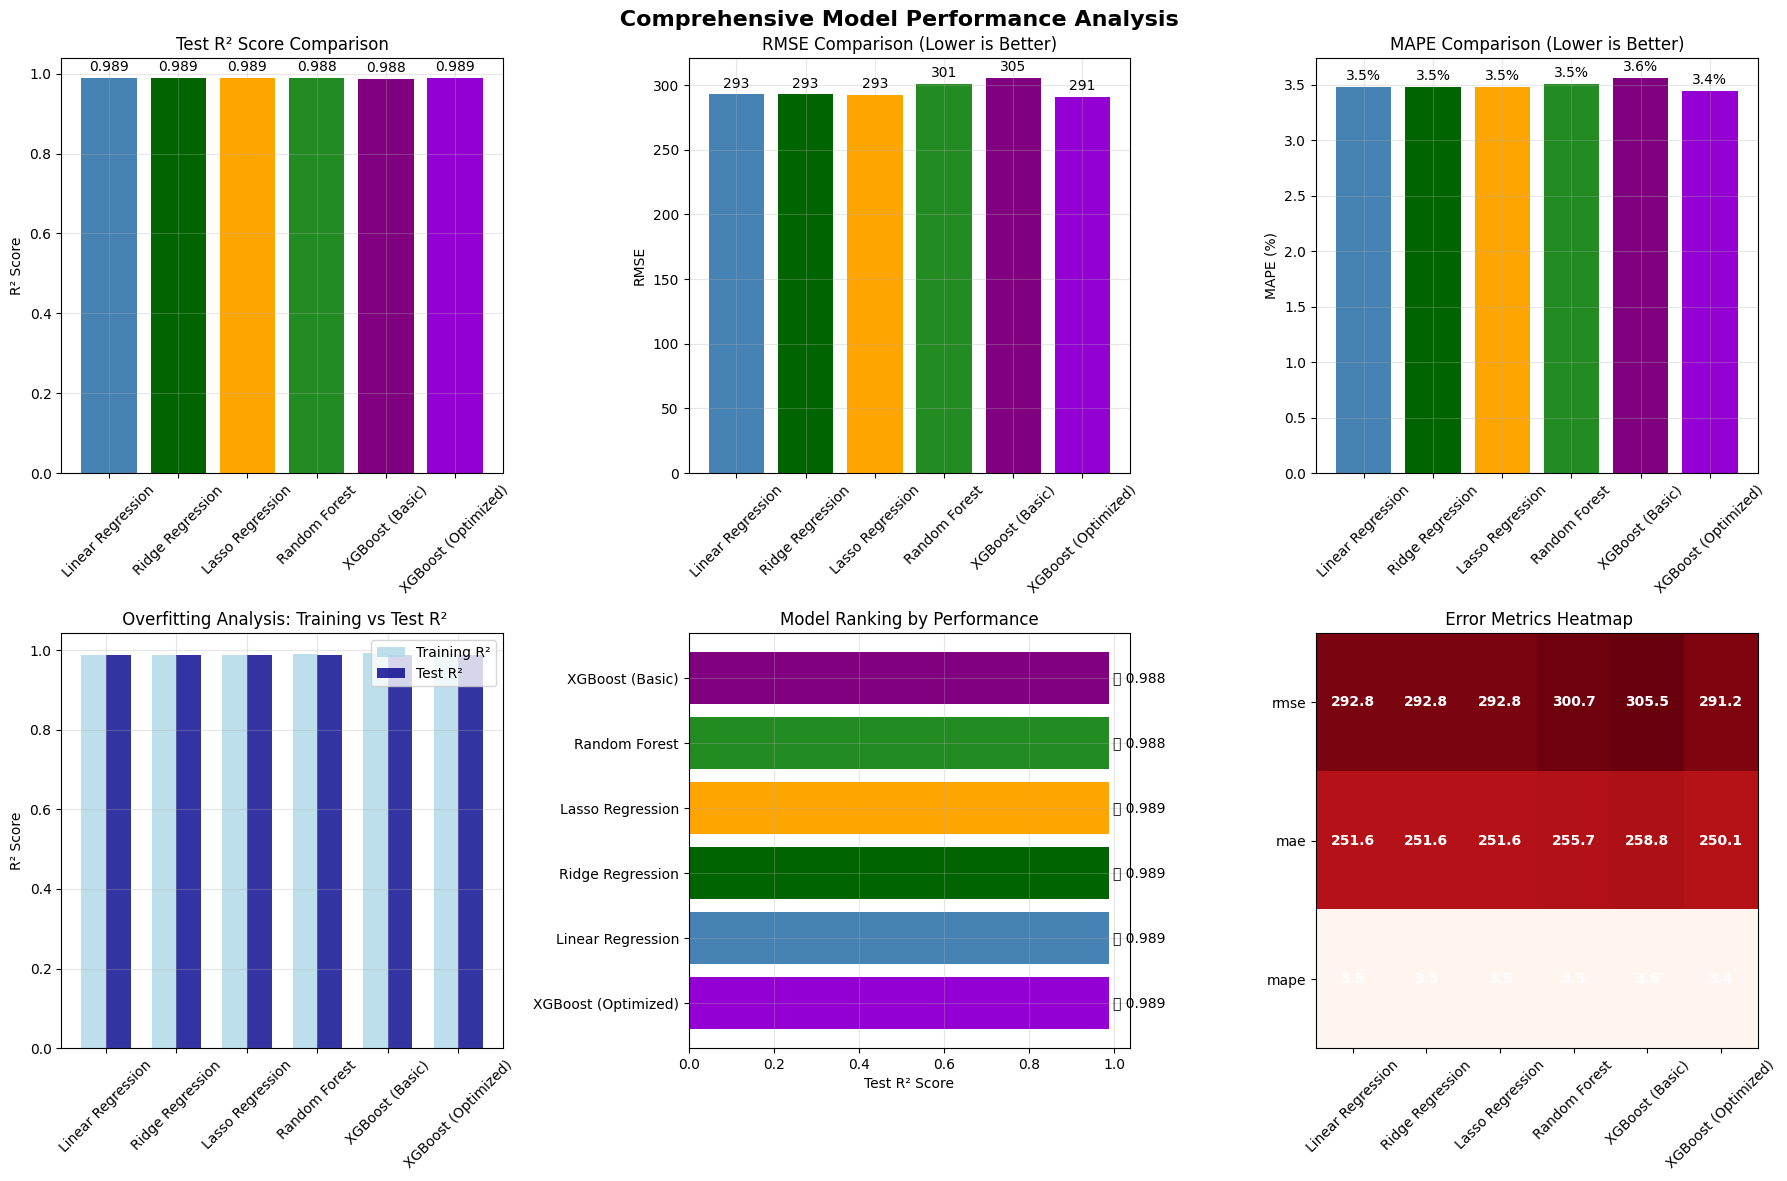


🏆 BEST PERFORMING MODEL: XGBoost (Optimized)
   📈 Test R² Score: 0.9889
   📉 RMSE: 291.19
   📊 MAPE: 3.45%

🔍 OVERFITTING ANALYSIS:
   Linear Regression: ✅ Low overfitting (-0.000)
   Ridge Regression: ✅ Low overfitting (-0.000)
   Lasso Regression: ✅ Low overfitting (-0.000)
   Random Forest: ✅ Low overfitting (0.002)
   XGBoost (Basic): ✅ Low overfitting (0.005)
   XGBoost (Optimized): ✅ Low overfitting (0.001)

💡 MODEL RECOMMENDATIONS:
   🥇 Best Overall: XGBoost (Optimized) (R² = 0.989)
   🎯 Most Stable: Linear Regression
   ⚡ Fastest Training: Linear Regression (baseline)
   🌳 Best for Interpretation: Random Forest (feature importance)


In [45]:
# Create comprehensive model performance comparison
results_df = pd.DataFrame(model_results).T
results_df = results_df.round(4)

print("🏆 COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("=" * 80)
print(results_df)

# Create detailed performance visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(' Comprehensive Model Performance Analysis', fontsize=16, fontweight='bold')

# Define colors for each model
colors = ['steelblue', 'darkgreen', 'orange', 'forestgreen', 'purple', 'darkviolet']
model_colors = dict(zip(results_df.index, colors[:len(results_df)]))

# 1. R² Score comparison
axes[0,0].bar(results_df.index, results_df['test_r2'], 
              color=[model_colors[model] for model in results_df.index])
axes[0,0].set_title('Test R² Score Comparison')
axes[0,0].set_ylabel('R² Score')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Add value labels on bars
for i, (model, score) in enumerate(zip(results_df.index, results_df['test_r2'])):
    axes[0,0].text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom', fontsize=10)

# 2. RMSE comparison
axes[0,1].bar(results_df.index, results_df['rmse'], 
              color=[model_colors[model] for model in results_df.index])
axes[0,1].set_title('RMSE Comparison (Lower is Better)')
axes[0,1].set_ylabel('RMSE')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Add value labels on bars
for i, (model, rmse) in enumerate(zip(results_df.index, results_df['rmse'])):
    axes[0,1].text(i, rmse + max(results_df['rmse'])*0.01, f'{rmse:.0f}', ha='center', va='bottom', fontsize=10)

# 3. MAPE comparison
axes[0,2].bar(results_df.index, results_df['mape'], 
              color=[model_colors[model] for model in results_df.index])
axes[0,2].set_title('MAPE Comparison (Lower is Better)')
axes[0,2].set_ylabel('MAPE (%)')
axes[0,2].tick_params(axis='x', rotation=45)
axes[0,2].grid(True, alpha=0.3)

# Add value labels on bars
for i, (model, mape) in enumerate(zip(results_df.index, results_df['mape'])):
    axes[0,2].text(i, mape + max(results_df['mape'])*0.01, f'{mape:.1f}%', ha='center', va='bottom', fontsize=10)

# 4. Training vs Test R² (Overfitting Analysis)
x = np.arange(len(results_df))
width = 0.35
axes[1,0].bar(x - width/2, results_df['train_r2'], width, label='Training R²', alpha=0.8, color='lightblue')
axes[1,0].bar(x + width/2, results_df['test_r2'], width, label='Test R²', alpha=0.8, color='darkblue')
axes[1,0].set_title(' Overfitting Analysis: Training vs Test R²')
axes[1,0].set_ylabel('R² Score')
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(results_df.index, rotation=45)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 5. Performance Ranking
performance_rank = results_df.sort_values('test_r2', ascending=False)
axes[1,1].barh(range(len(performance_rank)), performance_rank['test_r2'], 
               color=[model_colors[model] for model in performance_rank.index])
axes[1,1].set_yticks(range(len(performance_rank)))
axes[1,1].set_yticklabels(performance_rank.index)
axes[1,1].set_xlabel('Test R² Score')
axes[1,1].set_title('Model Ranking by Performance')
axes[1,1].grid(True, alpha=0.3)

# Add ranking medals
medals = ['🥇', '🥈', '🥉'] + ['🏅'] * (len(performance_rank) - 3)
for i, (medal, score) in enumerate(zip(medals, performance_rank['test_r2'])):
    axes[1,1].text(score + 0.01, i, f'{medal} {score:.3f}', va='center', fontsize=10)

# 6. Error Metrics Heatmap
error_metrics = results_df[['rmse', 'mae', 'mape']].T
im = axes[1,2].imshow(error_metrics.values, cmap='Reds', aspect='auto')
axes[1,2].set_xticks(range(len(error_metrics.columns)))
axes[1,2].set_xticklabels(error_metrics.columns, rotation=45)
axes[1,2].set_yticks(range(len(error_metrics.index)))
axes[1,2].set_yticklabels(error_metrics.index)
axes[1,2].set_title(' Error Metrics Heatmap')

# Add text annotations to heatmap
for i in range(len(error_metrics.index)):
    for j in range(len(error_metrics.columns)):
        text = axes[1,2].text(j, i, f'{error_metrics.iloc[i, j]:.1f}',
                             ha="center", va="center", color="white", fontweight='bold')

plt.tight_layout()
plt.show()

# Identify and highlight best performing model
best_model_name = results_df['test_r2'].idxmax()
best_rmse = results_df.loc[best_model_name, 'rmse']
best_r2 = results_df.loc[best_model_name, 'test_r2']
best_mape = results_df.loc[best_model_name, 'mape']

print(f"\n🏆 BEST PERFORMING MODEL: {best_model_name}")
print(f"   📈 Test R² Score: {best_r2:.4f}")
print(f"   📉 RMSE: {best_rmse:.2f}")
print(f"   📊 MAPE: {best_mape:.2f}%")

# Calculate and display overfitting analysis
print(f"\n🔍 OVERFITTING ANALYSIS:")
for model in results_df.index:
    overfitting = results_df.loc[model, 'train_r2'] - results_df.loc[model, 'test_r2']
    if overfitting > 0.1:
        status = "⚠️ High"
    elif overfitting < 0.05:
        status = "✅ Low"
    else:
        status = "⚡ Moderate"
    print(f"   {model}: {status} overfitting ({overfitting:.3f})")

# Model recommendations
print(f"\n💡 MODEL RECOMMENDATIONS:")
print(f"   🥇 Best Overall: {best_model_name} (R² = {best_r2:.3f})")
print(f"   🎯 Most Stable: {results_df.loc[results_df['train_r2'] - results_df['test_r2'] == (results_df['train_r2'] - results_df['test_r2']).min()].index[0]}")
print(f"   ⚡ Fastest Training: Linear Regression (baseline)")
print(f"   🌳 Best for Interpretation: Random Forest (feature importance)")

### 🔍 Model Segmentation Analysis 📊
Creating specialized models for different demographic segments to improve prediction accuracy.

In [46]:
# Select best model predictions for error analysis
best_model_mapping = {
    "Linear Regression": lr_model,
    "Ridge Regression": ridge_model,
    "Lasso Regression": lasso_model,
    "Random Forest": rf_model,
    "XGBoost (Basic)": xgb_model,
    "XGBoost (Optimized)": best_xgb_model
}

# Get predictions from the best model
if best_model_name == "XGBoost (Optimized)":
    y_pred_analysis = best_xgb_predictions
elif best_model_name == "Random Forest":
    y_pred_analysis = rf_predictions
elif best_model_name == "Ridge Regression":
    y_pred_analysis = ridge_predictions
elif best_model_name == "Lasso Regression":
    y_pred_analysis = lasso_predictions
elif best_model_name == "XGBoost (Basic)":
    y_pred_analysis = xgb_predictions
else:  # Linear Regression
    y_pred_analysis = lr_predictions

print(f"🎯 Using predictions from {best_model_name} for error analysis")
print(f"📊 Predictions shape: {y_pred_analysis.shape}")

🎯 Using predictions from XGBoost (Optimized) for error analysis
📊 Predictions shape: (6026,)


In [47]:
# 🔍 Demographic Segmentation Analysis
print("🎯 DEMOGRAPHIC SEGMENTATION FOR MODEL IMPROVEMENT")
print("=" * 60)

# Analyze prediction errors by demographic segments
def analyze_segment_errors(X_test, y_test, y_pred, segment_col, segment_name):
    """Analyze prediction errors for different segments"""
    
    # Calculate errors
    residual = y_pred - y_test
    abs_residual_pct = np.abs((residual / y_test) * 100)
    
    # Create analysis DataFrame
    segment_analysis = pd.DataFrame({
        'segment': X_test[segment_col] if segment_col in X_test.columns else 'N/A',
        'actual': y_test,
        'predicted': y_pred,
        'abs_error_pct': abs_residual_pct
    })
    
    if segment_col in X_test.columns:
        # Group by segment and calculate metrics
        segment_stats = segment_analysis.groupby('segment').agg({
            'abs_error_pct': ['mean', 'median', 'count'],
            'actual': 'mean',
            'predicted': 'mean'
        }).round(2)
        
        segment_stats.columns = ['Mean_Error_%', 'Median_Error_%', 'Count', 'Avg_Actual', 'Avg_Predicted']
        
        print(f"\n📊 {segment_name} Segment Analysis:")
        print(segment_stats)
        
        return segment_stats
    else:
        print(f"⚠️ Column {segment_col} not found in dataset")
        return None

# Convert scaled features back to original for segmentation
# Get the original columns that were scaled (from your earlier code)
original_scaled_cols = ['age','number_of_dependants', 'income_level', 'income_lakhs', 'insurance_plan','genetical_risk']

# Prepare full scaled features for inverse transform - need to reconstruct the original structure
full_scaled_features = X_test.copy()

# Add back the dropped 'income_level' column with zeros at the correct position
# Based on your VIF analysis, income_level was at index 2
full_scaled_features.insert(2, 'income_level', 0)

# Reorder to match the original scaler fit order
full_scaled_features = full_scaled_features[original_scaled_cols]

# Inverse transform to get original values
original_features = pd.DataFrame(
    scaler.inverse_transform(full_scaled_features),
    columns=original_scaled_cols,
    index=X_test.index
)

# Create age segments
age_bins = [0, 30, 45, 60, 100]
age_labels = ['Young (≤30)', 'Middle-aged (31-45)', 'Mature (46-60)', 'Senior (>60)']
original_features['age_segment'] = pd.cut(original_features['age'], bins=age_bins, labels=age_labels)

# Create income segments
income_bins = [0, 15, 30, 50, 1000]
income_labels = ['Low (≤15L)', 'Medium (15-30L)', 'High (30-50L)', 'Very High (>50L)']
original_features['income_segment'] = pd.cut(original_features['income_lakhs'], bins=income_bins, labels=income_labels)

# Add segments to X_test for analysis
X_test_with_segments = X_test.copy()
X_test_with_segments['age_segment'] = original_features['age_segment']
X_test_with_segments['income_segment'] = original_features['income_segment']
X_test_with_segments['insurance_plan_orig'] = original_features['insurance_plan']

# Analyze errors by different segments using best model predictions
age_stats = analyze_segment_errors(X_test_with_segments, y_test, y_pred_analysis, 'age_segment', 'Age')
income_stats = analyze_segment_errors(X_test_with_segments, y_test, y_pred_analysis, 'income_segment', 'Income')

# Insurance plan analysis
insurance_mapping = {1: 'Bronze', 2: 'Silver', 3: 'Gold'}
X_test_with_segments['insurance_plan_name'] = X_test_with_segments['insurance_plan_orig'].map(insurance_mapping)
insurance_stats = analyze_segment_errors(X_test_with_segments, y_test, y_pred_analysis, 'insurance_plan_name', 'Insurance Plan')

🎯 DEMOGRAPHIC SEGMENTATION FOR MODEL IMPROVEMENT

📊 Age Segment Analysis:
                     Mean_Error_%  Median_Error_%  Count  Avg_Actual  \
segment                                                                
Young (≤30)                  3.45            3.06   6026     8138.18   
Middle-aged (31-45)           NaN             NaN      0         NaN   
Mature (46-60)                NaN             NaN      0         NaN   
Senior (>60)                  NaN             NaN      0         NaN   

                     Avg_Predicted  
segment                             
Young (≤30)            8149.330078  
Middle-aged (31-45)            NaN  
Mature (46-60)                 NaN  
Senior (>60)                   NaN  

📊 Income Segment Analysis:
                  Mean_Error_%  Median_Error_%  Count  Avg_Actual  \
segment                                                             
Low (≤15L)                3.59            3.13   2945     7780.70   
Medium (15-30L)           3.56      

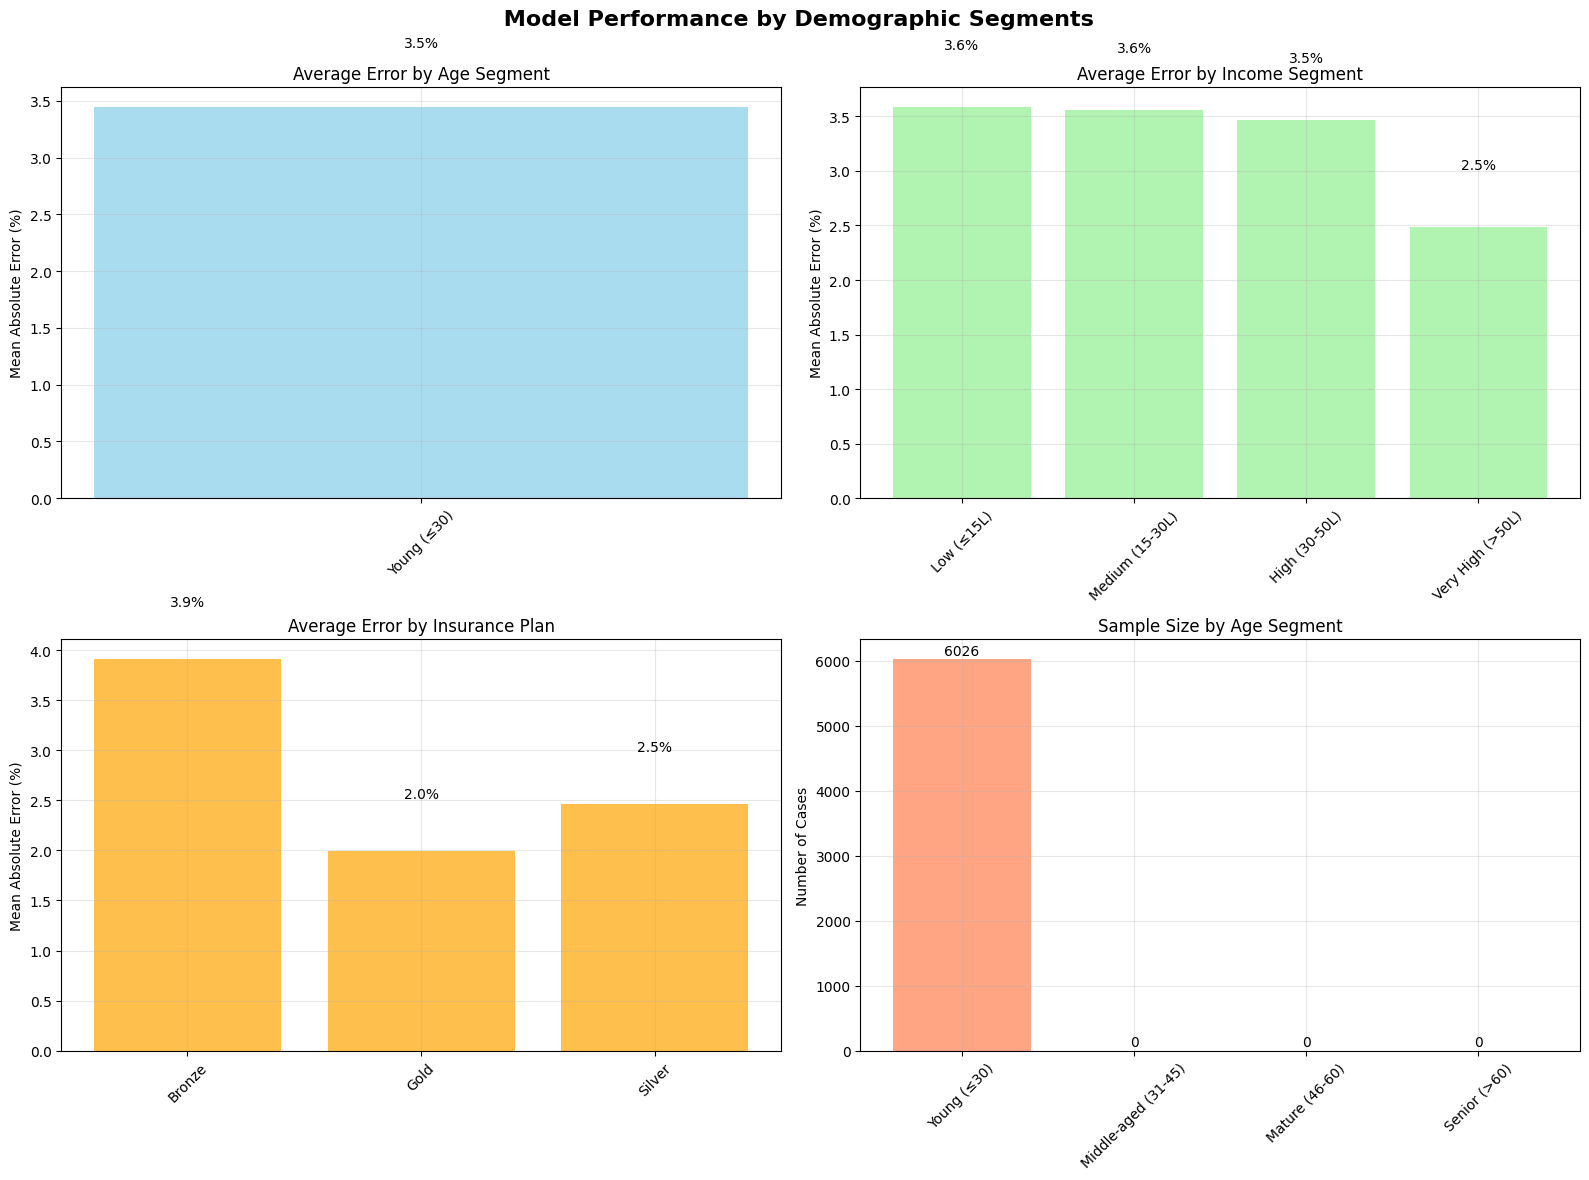

In [48]:
# Visualize segment performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(' Model Performance by Demographic Segments', fontsize=16, fontweight='bold')

# Age segment performance
if age_stats is not None:
    axes[0,0].bar(age_stats.index, age_stats['Mean_Error_%'], color='skyblue', alpha=0.7)
    axes[0,0].set_title('Average Error by Age Segment')
    axes[0,0].set_ylabel('Mean Absolute Error (%)')
    axes[0,0].tick_params(axis='x', rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(age_stats['Mean_Error_%']):
        axes[0,0].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

# Income segment performance
if income_stats is not None:
    axes[0,1].bar(income_stats.index, income_stats['Mean_Error_%'], color='lightgreen', alpha=0.7)
    axes[0,1].set_title('Average Error by Income Segment')
    axes[0,1].set_ylabel('Mean Absolute Error (%)')
    axes[0,1].tick_params(axis='x', rotation=45)
    axes[0,1].grid(True, alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(income_stats['Mean_Error_%']):
        axes[0,1].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

# Insurance plan performance
if insurance_stats is not None:
    axes[1,0].bar(insurance_stats.index, insurance_stats['Mean_Error_%'], color='orange', alpha=0.7)
    axes[1,0].set_title('Average Error by Insurance Plan')
    axes[1,0].set_ylabel('Mean Absolute Error (%)')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(insurance_stats['Mean_Error_%']):
        axes[1,0].text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

# Sample size by segments
if age_stats is not None:
    axes[1,1].bar(age_stats.index, age_stats['Count'], color='coral', alpha=0.7)
    axes[1,1].set_title('Sample Size by Age Segment')
    axes[1,1].set_ylabel('Number of Cases')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(age_stats['Count']):
        axes[1,1].text(i, v + 20, f'{v}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Export Model

In [49]:
cols_to_scale.remove('income_level')
cols_to_scale

['age',
 'number_of_dependants',
 'income_lakhs',
 'insurance_plan',
 'genetical_risk']

In [52]:
dump(rf_model,"artifact/model_young.joblib")

scale_with_col = {
	'scaler': scaler,
	'col_to_scale': cols_to_scale
}
dump(scale_with_col,"artifact/scaler_young.joblib")

['artifact/scaler_young.joblib']